
# Cats vs. Non-Cats — PyTorch (with Bayesian Optimization)

This notebook is a drop-in replacement for the TensorFlow version:
- Baseline custom CNN
- MobileNetV2 transfer-learning baseline
- Bayesian optimization via Optuna (maximize **val accuracy**)
- Early stopping + ReduceLROnPlateau
- Mixed precision on GPU
- Optional test metrics


In [1]:

# (Optional) If you need to install packages in this environment, uncomment:
# %pip install torch torchvision --index-url https://download.pytorch.org/whl/cu124
# %pip install optuna scikit-learn matplotlib


In [2]:

import os, json, time, math, shutil, zipfile
from dataclasses import dataclass, asdict
from typing import Dict, Tuple, Optional, List

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

from sklearn.metrics import roc_auc_score

import optuna
from optuna.samplers import TPESampler

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
AMP    = torch.cuda.is_available()
print("Using device:", DEVICE)


Using device: cuda


In [3]:

# Paths
zip_file_path = "cats-v-non-cats.zip"
extract_dir   = "cats-v-non-cats/"
TRAINING_DIR   = "cats-v-non-cats/training/"
VALIDATION_DIR = "cats-v-non-cats/validation/"
TESTING_DIR    = "cats-v-non-cats/test/"
INCLUDE_TEST   = True

# Extract (if zip present)
os.makedirs(extract_dir, exist_ok=True)
try:
    if os.path.exists(zip_file_path):
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            for info in zip_ref.infolist():
                if not info.filename.startswith('__MACOSX/'):
                    arcname = info.filename
                    if arcname.startswith('cats-v-non-cats/'):
                        arcname = arcname[len('cats-v-non-cats/'):]
                    if arcname:
                        info.filename = arcname
                        zip_ref.extract(info, extract_dir)
        macosx_folder = os.path.join(extract_dir, '__MACOSX')
        if os.path.exists(macosx_folder):
            shutil.rmtree(macosx_folder)
        print(f"File extracted to: {extract_dir}")
except Exception as e:
    print(f"An error occurred during unzipping: {e}")

# Baseline config (mirrors your TF keys)
BASELINE_CONFIG = {
    'learning_rate':      0.001,
    'reg_strength':       0.00001,   # weight decay
    'dropout_conv':       0.15,
    'dropout_dense':      0.4,
    'dense_units':        512,
    'filters_multiplier': 0.75,
    'batch_size':         128,
    'beta_1':             0.8,
    'beta_2':             0.99
}


File extracted to: cats-v-non-cats/


In [4]:

IMG_SIZE = 128

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomRotation(20),
    transforms.RandomAffine(0, translate=(0.2, 0.2), shear=0.2),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

def build_loaders(batch_size: int):
    train_ds = datasets.ImageFolder(TRAINING_DIR, transform=train_tfms)
    val_ds   = datasets.ImageFolder(VALIDATION_DIR, transform=val_tfms)
    kwargs = dict(num_workers=6, pin_memory=True, persistent_workers=True) if torch.cuda.is_available() else {}
    train_ld = DataLoader(train_ds, batch_size=batch_size, shuffle=True, **kwargs)
    val_ld   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, **kwargs)
    if INCLUDE_TEST and os.path.isdir(TESTING_DIR):
        test_ds = datasets.ImageFolder(TESTING_DIR, transform=val_tfms)
        test_ld = DataLoader(test_ds, batch_size=batch_size, shuffle=False, **kwargs)
    else:
        test_ld = None
    return train_ld, val_ld, test_ld, train_ds.class_to_idx


In [5]:

class CustomCNN(nn.Module):
    def __init__(self, reg_strength: float, dropout_conv: float, dropout_dense: float,
                 dense_units: int, filters_multiplier: float):
        super().__init__()
        f1 = max(8, int(32 * filters_multiplier))
        f2 = max(16, int(64 * filters_multiplier))
        f3 = max(32, int(128 * filters_multiplier))

        self.block1 = nn.Sequential(
            nn.Conv2d(3, f1, 3, padding=1), nn.ReLU(inplace=True),
            nn.BatchNorm2d(f1),
            nn.Conv2d(f1, f1, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_conv)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(f1, f2, 3, padding=1), nn.ReLU(inplace=True),
            nn.BatchNorm2d(f2),
            nn.Conv2d(f2, f2, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_conv)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(f2, f3, 3, padding=1), nn.ReLU(inplace=True),
            nn.BatchNorm2d(f3),
            nn.Conv2d(f3, f3, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_conv)
        )
        self.gap   = nn.AdaptiveAvgPool2d(1)
        self.head  = nn.Sequential(
            nn.Flatten(),
            nn.Linear(f3, dense_units), nn.ReLU(inplace=True),
            nn.BatchNorm1d(dense_units),
            nn.Dropout(dropout_dense),
            nn.Linear(dense_units, 1)  # binary logit
        )

    def forward(self, x):
        x = self.block1(x); x = self.block2(x); x = self.block3(x)
        x = self.gap(x)
        return self.head(x)

def build_mobilenet_v2(num_classes=1, dropout_dense=0.4, reg_strength=1e-4, train_base=False):
    m = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
    m.features.requires_grad_(train_base)
    in_features = m.classifier[-1].in_features
    m.classifier = nn.Sequential(
        nn.Dropout(p=dropout_dense),
        nn.Linear(in_features, 1)
    )
    return m


In [6]:

@torch.no_grad()
def eval_epoch(model, loader, device, amp=False):
    model.eval()
    loss_sum, n, correct = 0.0, 0, 0
    all_probs, all_labels = [], []
    criterion = nn.BCEWithLogitsLoss()

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        yf = y.float().to(device, non_blocking=True)
        with torch.cuda.amp.autocast(enabled=amp and device.type=='cuda'):
            logits = model(x).squeeze(1)
            loss = criterion(logits, yf)
        loss_sum += float(loss.item()) * x.size(0)
        n += x.size(0)
        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).long().cpu()
        correct += int((preds == y.cpu()).sum().item())
        all_probs.extend(probs.detach().cpu().tolist())
        all_labels.extend(y.cpu().tolist())

    val_loss = loss_sum / max(1, n)
    val_acc  = correct / max(1, n)
    try:
        if len(set(all_labels)) == 2:
            val_auc = roc_auc_score(all_labels, np.array(all_probs))
        else:
            val_auc = float("nan")
    except Exception:
        val_auc = float("nan")
    return val_loss, val_acc, val_auc


In [7]:

def train_and_evaluate_model(config: Dict, epochs: int = 5,
                             param_name: Optional[str] = None,
                             param_value: Optional[str] = None) -> Dict:
    batch_size     = int(config['batch_size'])
    lr             = float(config['learning_rate'])
    weight_decay   = float(config['reg_strength'])
    dropout_conv   = float(config['dropout_conv'])
    dropout_dense  = float(config['dropout_dense'])
    dense_units    = int(config['dense_units'])
    filt_mult      = float(config['filters_multiplier'])
    beta1          = float(config['beta_1'])
    beta2          = float(config['beta_2'])

    train_ld, val_ld, test_ld, class_to_idx = build_loaders(batch_size)
    model = CustomCNN(weight_decay, dropout_conv, dropout_dense, dense_units, filt_mult).to(DEVICE)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(beta1, beta2), weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=5, verbose=True)
    criterion = nn.BCEWithLogitsLoss()
    scaler = torch.cuda.amp.GradScaler(enabled=AMP)

    patience = 15
    best_acc, best_state, wait = -1.0, None, 0
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': [], 'val_auc': []}

    for epoch in range(epochs):
        model.train()
        epoch_loss, epoch_correct, n = 0.0, 0, 0
        for x, y in train_ld:
            x = x.to(DEVICE, non_blocking=True)
            y = y.float().to(DEVICE, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=AMP):
                logits = model(x).squeeze(1)
                loss   = criterion(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            epoch_loss += float(loss.item()) * x.size(0)
            preds = (torch.sigmoid(logits) >= 0.5).long()
            epoch_correct += int((preds.cpu() == y.cpu().long()).sum().item())
            n += x.size(0)

        train_loss = epoch_loss / max(1, n)
        train_acc  = epoch_correct / max(1, n)
        val_loss, val_acc, val_auc = eval_epoch(model, val_ld, DEVICE, amp=AMP)

        history['loss'].append(train_loss)
        history['accuracy'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc)
        history['val_auc'].append(val_auc)

        scheduler.step(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch+1}; best val_acc={best_acc:.4f}")
                break

        print(f"Epoch {epoch+1}/{epochs}  "
              f"loss={train_loss:.4f} acc={train_acc:.4f}  "
              f"val_loss={val_loss:.4f} val_acc={val_acc:.4f} val_auc={val_auc:.4f}")

    if best_state is not None:
        model.load_state_dict({k: v.to(DEVICE) for k, v in best_state.items()})

    val_loss, val_acc, val_auc = eval_epoch(model, val_ld, DEVICE, amp=AMP)
    results = {
        'val_accuracy': float(val_acc),
        'val_auc': float(val_auc),
        'val_loss': float(val_loss),
        'history': history,
        'batch_size_used': batch_size
    }
    if INCLUDE_TEST and (test_ld is not None):
        test_loss, test_acc, test_auc = eval_epoch(model, test_ld, DEVICE, amp=AMP)
        results.update({'test_accuracy': float(test_acc), 'test_auc': float(test_auc), 'test_loss': float(test_loss)})
    return results


In [8]:

def train_and_evaluate_mobilenet(config: Dict, epochs: int = 5) -> Dict:
    batch_size    = int(config['batch_size'])
    lr            = float(config['learning_rate'])
    weight_decay  = float(config.get('reg_strength', 1e-4))
    dropout_dense = float(config.get('dropout_dense', 0.4))
    beta1         = float(config['beta_1'])
    beta2         = float(config['beta_2'])

    train_ld, val_ld, test_ld, _ = build_loaders(batch_size)
    model = build_mobilenet_v2(dropout_dense=dropout_dense, reg_strength=weight_decay, train_base=False).to(DEVICE)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(beta1,beta2), weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=5, verbose=True)
    criterion = nn.BCEWithLogitsLoss()
    scaler = torch.cuda.amp.GradScaler(enabled=AMP)

    patience = 15
    best_acc, best_state, wait = -1.0, None, 0
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': [], 'val_auc': []}

    for epoch in range(epochs):
        model.train()
        epoch_loss, epoch_correct, n = 0.0, 0, 0
        for x, y in train_ld:
            x = x.to(DEVICE, non_blocking=True); y = y.float().to(DEVICE, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=AMP):
                logits = model(x).squeeze(1)
                loss   = criterion(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer); scaler.update()

            epoch_loss += float(loss.item()) * x.size(0)
            preds = (torch.sigmoid(logits) >= 0.5).long()
            epoch_correct += int((preds.cpu() == y.cpu().long()).sum().item())
            n += x.size(0)

        train_loss = epoch_loss / max(1, n)
        train_acc  = epoch_correct / max(1, n)
        val_loss, val_acc, val_auc = eval_epoch(model, val_ld, DEVICE, amp=AMP)

        history['loss'].append(train_loss)
        history['accuracy'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc)
        history['val_auc'].append(val_auc)

        scheduler.step(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch+1}; best val_acc={best_acc:.4f}")
                break

        print(f"[MobileNetV2] Epoch {epoch+1}/{epochs}  "
              f"loss={train_loss:.4f} acc={train_acc:.4f}  "
              f"val_loss={val_loss:.4f} val_acc={val_acc:.4f} val_auc={val_auc:.4f}")

    if best_state is not None:
        model.load_state_dict({k: v.to(DEVICE) for k, v in best_state.items()})

    val_loss, val_acc, val_auc = eval_epoch(model, val_ld, DEVICE, amp=AMP)
    results = {'val_accuracy': float(val_acc), 'val_auc': float(val_auc), 'val_loss': float(val_loss),
               'history': history, 'batch_size_used': batch_size}
    if INCLUDE_TEST and (test_ld is not None):
        test_loss, test_acc, test_auc = eval_epoch(model, test_ld, DEVICE, amp=AMP)
        results.update({'test_accuracy': float(test_acc), 'test_auc': float(test_auc), 'test_loss': float(test_loss)})
    return results


In [14]:

def objective(trial: optuna.trial.Trial) -> float:
    config = {
        'learning_rate':      trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
        'reg_strength':       trial.suggest_float('reg_strength', 1e-6, 1e-2, log=True),
        'dropout_conv':       trial.suggest_float('dropout_conv', 0.1, 0.4),
        'dropout_dense':      trial.suggest_float('dropout_dense', 0.2, 0.7),
        'dense_units':        trial.suggest_categorical('dense_units', [128, 256, 512, 1024, 2048]),
        'filters_multiplier': trial.suggest_float('filters_multiplier', 0.5, 2.0),
        'batch_size':         trial.suggest_categorical('batch_size', [16, 32, 64, 128]),
        'beta_1':             trial.suggest_float('beta_1', 0.7, 0.99),
        'beta_2':             trial.suggest_float('beta_2', 0.9, 0.9999)
    }
    result = train_and_evaluate_model(config, epochs=30, param_name=f"trial_{trial.number}", param_value="bayesian")
    trial.set_user_attr('val_auc',  result['val_auc'])
    trial.set_user_attr('val_loss', result['val_loss'])
    acc = float(result['val_accuracy'])
    print(f"Trial {trial.number}: Accuracy = {acc:.4f}")
    return acc

def run_bayesian_optimization(n_trials=50, timeout=None):
    print(f"Starting Bayesian Optimization with {n_trials} trials...")
    study = optuna.create_study(direction='maximize',
                                sampler=TPESampler(seed=42),
                                study_name='cnn_hyperparameter_optimization_pytorch')
    study.optimize(objective, n_trials=n_trials, timeout=timeout)
    print("\n" + "="*60)
    print("BAYESIAN OPTIMIZATION RESULTS")
    print("="*60)
    print(f"Number of finished trials: {len(study.trials)}")
    print(f"Best trial number: {study.best_trial.number}")
    print(f"Best validation accuracy: {study.best_value:.4f}")
    print("\n🏆 Best hyperparameters:")
    for k, v in study.best_params.items():
        print(f"  {k}: {v}")
    bt = study.best_trial
    if 'val_auc' in bt.user_attrs:
        print("\nBest trial metrics:")
        print(f"  Validation AUC:  {bt.user_attrs['val_auc']:.4f}")
        print(f"  Validation Loss: {bt.user_attrs['val_loss']:.4f}")
    return study


In [10]:

print("Training baseline model...")
baseline_result = train_and_evaluate_model(BASELINE_CONFIG, epochs=50)
print("\nBaseline Results:")
print(f"Accuracy: {baseline_result['val_accuracy']:.4f}")
print(f"AUC:      {baseline_result['val_auc']:.4f}")
print(f"Loss:     {baseline_result['val_loss']:.4f}")

print("\nTraining MobileNetV2 baseline (transfer learning)...")
mobilenet_config = BASELINE_CONFIG.copy()
mobilenet_result = train_and_evaluate_mobilenet(mobilenet_config, epochs=10)
print("\nMobileNetV2 Baseline Results:")
print(f"Accuracy: {mobilenet_result['val_accuracy']:.4f}")
print(f"AUC:      {mobilenet_result['val_auc']:.4f}")
print(f"Loss:     {mobilenet_result['val_loss']:.4f}")

print('\n=== QUICK COMPARISON ===')
try:
    print(f"Custom CNN  - Accuracy: {baseline_result['val_accuracy']:.4f}, AUC: {baseline_result['val_auc']:.4f}")
    print(f"MobileNetV2 - Accuracy: {mobilenet_result['val_accuracy']:.4f}, AUC: {mobilenet_result['val_auc']:.4f}")
    acc_diff = mobilenet_result['val_accuracy'] - baseline_result['val_accuracy']
    print(f"Accuracy diff (MobileNet - Custom): {acc_diff:+.4f}")
except Exception as e:
    print('Comparison failed:', e)


Training baseline model...


c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50  loss=0.5471 acc=0.7240  val_loss=0.5519 val_acc=0.7285 val_auc=0.8513
Epoch 2/50  loss=0.4588 acc=0.7864  val_loss=0.4294 val_acc=0.8006 val_auc=0.8975
Epoch 3/50  loss=0.4020 acc=0.8207  val_loss=0.3906 val_acc=0.8287 val_auc=0.9214
Epoch 4/50  loss=0.3817 acc=0.8335  val_loss=0.4218 val_acc=0.8268 val_auc=0.8996
Epoch 5/50  loss=0.3621 acc=0.8474  val_loss=0.3741 val_acc=0.8343 val_auc=0.9154
Epoch 6/50  loss=0.3333 acc=0.8583  val_loss=0.6709 val_acc=0.7182 val_auc=0.9064
Epoch 7/50  loss=0.3221 acc=0.8611  val_loss=0.4267 val_acc=0.8212 val_auc=0.9405
Epoch 8/50  loss=0.3044 acc=0.8744  val_loss=0.3184 val_acc=0.8708 val_auc=0.9594
Epoch 9/50  loss=0.2820 acc=0.8846  val_loss=0.5196 val_acc=0.7912 val_auc=0.8927
Epoch 10/50  loss=0.2751 acc=0.8851  val_loss=0.3448 val_acc=0.8736 val_auc=0.9400
Epoch 11/50  loss=0.2694 acc=0.8921  val_loss=0.2702 val_acc=0.8961 val_auc=0.9604
Epoch 12/50  loss=0.2556 acc=0.8938  val_loss=0.2483 val_acc=0.9045 val_auc=0.9630
Epoch 13/50  

c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[MobileNetV2] Epoch 1/10  loss=0.3586 acc=0.8570  val_loss=0.1726 val_acc=0.9466 val_auc=0.9902
[MobileNetV2] Epoch 2/10  loss=0.2369 acc=0.9153  val_loss=0.1503 val_acc=0.9410 val_auc=0.9924
[MobileNetV2] Epoch 3/10  loss=0.2111 acc=0.9201  val_loss=0.1463 val_acc=0.9373 val_auc=0.9930
[MobileNetV2] Epoch 4/10  loss=0.2070 acc=0.9195  val_loss=0.1191 val_acc=0.9551 val_auc=0.9934
[MobileNetV2] Epoch 5/10  loss=0.1945 acc=0.9252  val_loss=0.1263 val_acc=0.9494 val_auc=0.9935
[MobileNetV2] Epoch 6/10  loss=0.1881 acc=0.9251  val_loss=0.1351 val_acc=0.9485 val_auc=0.9934
[MobileNetV2] Epoch 7/10  loss=0.1871 acc=0.9261  val_loss=0.1399 val_acc=0.9429 val_auc=0.9936
[MobileNetV2] Epoch 8/10  loss=0.1923 acc=0.9251  val_loss=0.1056 val_acc=0.9579 val_auc=0.9935
[MobileNetV2] Epoch 9/10  loss=0.1876 acc=0.9236  val_loss=0.1192 val_acc=0.9560 val_auc=0.9938
[MobileNetV2] Epoch 10/10  loss=0.1763 acc=0.9291  val_loss=0.1175 val_acc=0.9532 val_auc=0.9938

MobileNetV2 Baseline Results:
Accuracy

In [15]:

study = run_bayesian_optimization(n_trials=50)


Epoch 25/30  loss=0.2169 acc=0.9176  val_loss=0.2675 val_acc=0.8979 val_auc=0.9795
Epoch 26/30  loss=0.2141 acc=0.9167  val_loss=0.2592 val_acc=0.9007 val_auc=0.9801
Epoch 27/30  loss=0.2105 acc=0.9139  val_loss=0.3241 val_acc=0.8764 val_auc=0.9734
Epoch 28/30  loss=0.2049 acc=0.9194  val_loss=0.2897 val_acc=0.8839 val_auc=0.9774
Epoch 29/30  loss=0.2039 acc=0.9222  val_loss=0.2799 val_acc=0.8914 val_auc=0.9797
Epoch 30/30  loss=0.1997 acc=0.9201  val_loss=0.2718 val_acc=0.8923 val_auc=0.9800


[I 2025-10-20 22:08:50,701] Trial 3 finished with value: 0.903558052434457 and parameters: {'learning_rate': 0.0015375920235481753, 'reg_strength': 5.4880470007660465e-06, 'dropout_conv': 0.39087538832936763, 'dropout_dense': 0.5875664116805572, 'dense_units': 128, 'filters_multiplier': 0.7939742936287177, 'batch_size': 64, 'beta_1': 0.9403338776540595, 'beta_2': 0.9356396573366896}. Best is trial 1 with value: 0.9456928838951311.


Trial 3: Accuracy = 0.9036


c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/30  loss=0.5470 acc=0.7258  val_loss=0.4722 val_acc=0.7818 val_auc=0.8555
Epoch 2/30  loss=0.4657 acc=0.7844  val_loss=0.5406 val_acc=0.7603 val_auc=0.8589
Epoch 3/30  loss=0.4229 acc=0.8103  val_loss=0.3763 val_acc=0.8380 val_auc=0.9264
Epoch 4/30  loss=0.3887 acc=0.8294  val_loss=0.4682 val_acc=0.8099 val_auc=0.9081
Epoch 5/30  loss=0.3539 acc=0.8467  val_loss=0.3504 val_acc=0.8586 val_auc=0.9271
Epoch 6/30  loss=0.3303 acc=0.8634  val_loss=0.3624 val_acc=0.8614 val_auc=0.9398
Epoch 7/30  loss=0.3164 acc=0.8634  val_loss=0.4088 val_acc=0.8390 val_auc=0.9219
Epoch 8/30  loss=0.3054 acc=0.8702  val_loss=0.3122 val_acc=0.8745 val_auc=0.9452
Epoch 9/30  loss=0.2945 acc=0.8769  val_loss=0.2586 val_acc=0.8876 val_auc=0.9632
Epoch 10/30  loss=0.2702 acc=0.8902  val_loss=0.2824 val_acc=0.8830 val_auc=0.9573
Epoch 11/30  loss=0.2582 acc=0.8962  val_loss=0.3086 val_acc=0.8839 val_auc=0.9641
Epoch 12/30  loss=0.2448 acc=0.9023  val_loss=0.3341 val_acc=0.8839 val_auc=0.9631
Epoch 13/30  

[I 2025-10-20 22:14:36,576] Trial 4 finished with value: 0.9344569288389513 and parameters: {'learning_rate': 0.000132965214572995, 'reg_strength': 0.00014817820606039095, 'dropout_conv': 0.1422772674924288, 'dropout_dense': 0.6010984903770198, 'dense_units': 256, 'filters_multiplier': 1.7231921426822512, 'batch_size': 64, 'beta_1': 0.803955061277839, 'beta_2': 0.9115753190465605}. Best is trial 1 with value: 0.9456928838951311.


Trial 4: Accuracy = 0.9345


c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/30  loss=1.0887 acc=0.5534  val_loss=14.7417 val_acc=0.5000 val_auc=0.5000
Epoch 2/30  loss=0.6587 acc=0.6390  val_loss=0.6478 val_acc=0.6227 val_auc=0.6770
Epoch 3/30  loss=0.6369 acc=0.6367  val_loss=0.6899 val_acc=0.5047 val_auc=0.7546
Epoch 4/30  loss=0.6178 acc=0.6684  val_loss=0.6961 val_acc=0.5197 val_auc=0.7575
Epoch 5/30  loss=0.6264 acc=0.6465  val_loss=0.8967 val_acc=0.5000 val_auc=0.7326
Epoch 6/30  loss=0.6257 acc=0.6582  val_loss=0.6207 val_acc=0.5674 val_auc=0.7875
Epoch 7/30  loss=0.5925 acc=0.6784  val_loss=0.7633 val_acc=0.6049 val_auc=0.7949
Epoch 8/30  loss=0.5971 acc=0.6801  val_loss=1.2446 val_acc=0.6404 val_auc=0.7831
Epoch 9/30  loss=0.5862 acc=0.6915  val_loss=0.6655 val_acc=0.7060 val_auc=0.7731
Epoch 10/30  loss=0.5732 acc=0.7056  val_loss=0.6615 val_acc=0.7350 val_auc=0.7999
Epoch 11/30  loss=0.5662 acc=0.7186  val_loss=1.3096 val_acc=0.5974 val_auc=0.7783
Epoch 12/30  loss=0.5492 acc=0.7289  val_loss=0.5273 val_acc=0.7556 val_auc=0.8380
Epoch 13/30 

[I 2025-10-20 22:20:17,611] Trial 5 finished with value: 0.8333333333333334 and parameters: {'learning_rate': 0.028340904295147733, 'reg_strength': 0.0003113095956122125, 'dropout_conv': 0.19926940745579477, 'dropout_dense': 0.23177917514301183, 'dense_units': 2048, 'filters_multiplier': 1.2083223877429239, 'batch_size': 64, 'beta_1': 0.9235804821868226, 'beta_2': 0.9493301800768027}. Best is trial 1 with value: 0.9456928838951311.


Trial 5: Accuracy = 0.8333


c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/30  loss=0.5800 acc=0.7121  val_loss=0.5524 val_acc=0.7818 val_auc=0.8571
Epoch 2/30  loss=0.5001 acc=0.7635  val_loss=0.5714 val_acc=0.7884 val_auc=0.8859
Epoch 3/30  loss=0.4451 acc=0.7975  val_loss=0.7016 val_acc=0.6957 val_auc=0.8606
Epoch 4/30  loss=0.4081 acc=0.8258  val_loss=0.3967 val_acc=0.8493 val_auc=0.9241
Epoch 5/30  loss=0.3853 acc=0.8425  val_loss=0.3327 val_acc=0.8633 val_auc=0.9336
Epoch 6/30  loss=0.3545 acc=0.8531  val_loss=0.3114 val_acc=0.8783 val_auc=0.9484
Epoch 7/30  loss=0.3472 acc=0.8556  val_loss=0.3068 val_acc=0.8680 val_auc=0.9458
Epoch 8/30  loss=0.3203 acc=0.8700  val_loss=0.3420 val_acc=0.8652 val_auc=0.9441
Epoch 9/30  loss=0.3233 acc=0.8693  val_loss=0.3120 val_acc=0.8736 val_auc=0.9553
Epoch 10/30  loss=0.3148 acc=0.8725  val_loss=0.3361 val_acc=0.8493 val_auc=0.9621
Epoch 11/30  loss=0.2955 acc=0.8790  val_loss=0.2623 val_acc=0.8970 val_auc=0.9643
Epoch 12/30  loss=0.2949 acc=0.8772  val_loss=0.2414 val_acc=0.9045 val_auc=0.9648
Epoch 13/30  

[I 2025-10-20 22:25:52,999] Trial 6 finished with value: 0.9438202247191011 and parameters: {'learning_rate': 0.0012329098365270509, 'reg_strength': 5.1305517605898387e-05, 'dropout_conv': 0.10762573802322856, 'dropout_dense': 0.25394571349665224, 'dense_units': 2048, 'filters_multiplier': 0.8739383437233124, 'batch_size': 32, 'beta_1': 0.7840279213449927, 'beta_2': 0.9161060065966751}. Best is trial 1 with value: 0.9456928838951311.


Trial 6: Accuracy = 0.9438


c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/30  loss=0.9241 acc=0.5610  val_loss=0.7396 val_acc=0.5000 val_auc=0.5771
Epoch 2/30  loss=0.6432 acc=0.6319  val_loss=0.6942 val_acc=0.5000 val_auc=0.7426
Epoch 3/30  loss=0.6231 acc=0.6530  val_loss=0.8476 val_acc=0.5000 val_auc=0.6994
Epoch 4/30  loss=0.6111 acc=0.6726  val_loss=1.1818 val_acc=0.5000 val_auc=0.5937
Epoch 5/30  loss=0.6218 acc=0.6550  val_loss=0.6101 val_acc=0.6236 val_auc=0.7704
Epoch 6/30  loss=0.6291 acc=0.6485  val_loss=0.6648 val_acc=0.4850 val_auc=0.6470
Epoch 7/30  loss=0.6345 acc=0.6429  val_loss=2.2101 val_acc=0.5000 val_auc=0.7360
Epoch 8/30  loss=0.6317 acc=0.6510  val_loss=0.5860 val_acc=0.6845 val_auc=0.7323
Epoch 9/30  loss=0.6238 acc=0.6533  val_loss=0.5855 val_acc=0.6704 val_auc=0.7656
Epoch 10/30  loss=0.6279 acc=0.6516  val_loss=0.5962 val_acc=0.7144 val_auc=0.7850
Epoch 11/30  loss=0.6238 acc=0.6596  val_loss=0.5837 val_acc=0.7116 val_auc=0.7489
Epoch 12/30  loss=0.6263 acc=0.6490  val_loss=0.5889 val_acc=0.6873 val_auc=0.7387
Epoch 13/30  

[I 2025-10-20 22:31:41,524] Trial 7 finished with value: 0.7911985018726592 and parameters: {'learning_rate': 0.05233480488540085, 'reg_strength': 0.0017079750342958238, 'dropout_conv': 0.2900211269531271, 'dropout_dense': 0.6357302950938588, 'dense_units': 512, 'filters_multiplier': 1.8441369498852398, 'batch_size': 128, 'beta_1': 0.937224282117523, 'beta_2': 0.9859869852673088}. Best is trial 1 with value: 0.9456928838951311.


Trial 7: Accuracy = 0.7912


c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/30  loss=0.5671 acc=0.7042  val_loss=0.8086 val_acc=0.6433 val_auc=0.7874
Epoch 2/30  loss=0.5247 acc=0.7331  val_loss=0.8172 val_acc=0.6564 val_auc=0.7682
Epoch 3/30  loss=0.5008 acc=0.7523  val_loss=1.1390 val_acc=0.6292 val_auc=0.7568
Epoch 4/30  loss=0.4718 acc=0.7817  val_loss=0.9815 val_acc=0.6489 val_auc=0.7965
Epoch 5/30  loss=0.4622 acc=0.7856  val_loss=1.1375 val_acc=0.6348 val_auc=0.7780
Epoch 6/30  loss=0.4500 acc=0.7864  val_loss=1.4510 val_acc=0.6217 val_auc=0.7801
Epoch 7/30  loss=0.4440 acc=0.7934  val_loss=1.3405 val_acc=0.6348 val_auc=0.7664
Epoch 8/30  loss=0.4350 acc=0.8024  val_loss=1.4969 val_acc=0.6283 val_auc=0.7274
Epoch 9/30  loss=0.4274 acc=0.8038  val_loss=1.4730 val_acc=0.6442 val_auc=0.7416
Epoch 10/30  loss=0.4153 acc=0.8184  val_loss=1.6079 val_acc=0.6283 val_auc=0.7451
Epoch 11/30  loss=0.4164 acc=0.8114  val_loss=1.5976 val_acc=0.6348 val_auc=0.7456
Epoch 12/30  loss=0.4152 acc=0.8140  val_loss=1.5114 val_acc=0.6404 val_auc=0.7542
Epoch 13/30  

[I 2025-10-20 22:35:05,070] Trial 8 finished with value: 0.6563670411985019 and parameters: {'learning_rate': 1.0661259689433896e-05, 'reg_strength': 0.00011040511903162256, 'dropout_conv': 0.22522330094463372, 'dropout_dense': 0.31105390523536514, 'dense_units': 512, 'filters_multiplier': 1.5545284383427669, 'batch_size': 32, 'beta_1': 0.8442020667087917, 'beta_2': 0.9300577431506953}. Best is trial 1 with value: 0.9456928838951311.


Trial 8: Accuracy = 0.6564


c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/30  loss=0.5511 acc=0.7179  val_loss=0.6147 val_acc=0.6826 val_auc=0.8432
Epoch 2/30  loss=0.4801 acc=0.7768  val_loss=0.4038 val_acc=0.8268 val_auc=0.9052
Epoch 3/30  loss=0.4193 acc=0.8090  val_loss=0.3622 val_acc=0.8483 val_auc=0.9279
Epoch 4/30  loss=0.3971 acc=0.8269  val_loss=0.3724 val_acc=0.8474 val_auc=0.9173
Epoch 5/30  loss=0.3700 acc=0.8393  val_loss=0.2686 val_acc=0.8979 val_auc=0.9564
Epoch 6/30  loss=0.3478 acc=0.8476  val_loss=0.3555 val_acc=0.8511 val_auc=0.9272
Epoch 7/30  loss=0.3293 acc=0.8625  val_loss=0.3028 val_acc=0.8783 val_auc=0.9554
Epoch 8/30  loss=0.3258 acc=0.8638  val_loss=0.3167 val_acc=0.8792 val_auc=0.9585
Epoch 9/30  loss=0.3077 acc=0.8768  val_loss=0.2410 val_acc=0.8970 val_auc=0.9663
Epoch 10/30  loss=0.2969 acc=0.8745  val_loss=0.2527 val_acc=0.9045 val_auc=0.9618
Epoch 11/30  loss=0.2852 acc=0.8846  val_loss=0.2495 val_acc=0.9026 val_auc=0.9648
Epoch 12/30  loss=0.2821 acc=0.8835  val_loss=0.2291 val_acc=0.9064 val_auc=0.9684
Epoch 13/30  

[I 2025-10-20 22:41:05,869] Trial 9 finished with value: 0.9410112359550562 and parameters: {'learning_rate': 0.00013783578294796384, 'reg_strength': 1.4045842344024705e-06, 'dropout_conv': 0.28286930019396905, 'dropout_dense': 0.4513395116144307, 'dense_units': 512, 'filters_multiplier': 1.2341791404163445, 'batch_size': 16, 'beta_1': 0.7689148877577958, 'beta_2': 0.9727488132263248}. Best is trial 1 with value: 0.9456928838951311.


Trial 9: Accuracy = 0.9410


c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/30  loss=0.6342 acc=0.6492  val_loss=0.5898 val_acc=0.7388 val_auc=0.7993
Epoch 2/30  loss=0.5706 acc=0.7082  val_loss=0.6700 val_acc=0.6423 val_auc=0.8553
Epoch 3/30  loss=0.5257 acc=0.7454  val_loss=0.5790 val_acc=0.7041 val_auc=0.8648
Epoch 4/30  loss=0.5145 acc=0.7549  val_loss=0.5984 val_acc=0.7378 val_auc=0.8436
Epoch 5/30  loss=0.5043 acc=0.7681  val_loss=0.4754 val_acc=0.7846 val_auc=0.8578
Epoch 6/30  loss=0.4776 acc=0.7749  val_loss=0.6915 val_acc=0.6536 val_auc=0.8783
Epoch 7/30  loss=0.4694 acc=0.7824  val_loss=0.3982 val_acc=0.8455 val_auc=0.9098
Epoch 8/30  loss=0.4551 acc=0.7913  val_loss=0.6621 val_acc=0.7313 val_auc=0.8893
Epoch 9/30  loss=0.4460 acc=0.7993  val_loss=0.5538 val_acc=0.7556 val_auc=0.8956
Epoch 10/30  loss=0.4328 acc=0.8116  val_loss=0.4386 val_acc=0.8090 val_auc=0.9061
Epoch 11/30  loss=0.4313 acc=0.8041  val_loss=0.4997 val_acc=0.7650 val_auc=0.9129
Epoch 12/30  loss=0.4196 acc=0.8150  val_loss=0.4473 val_acc=0.7818 val_auc=0.9263
Epoch 13/30  

[I 2025-10-20 22:46:59,736] Trial 10 finished with value: 0.8932584269662921 and parameters: {'learning_rate': 0.009908765478430503, 'reg_strength': 2.8504320627871546e-05, 'dropout_conv': 0.18102285590352837, 'dropout_dense': 0.34456342667644324, 'dense_units': 128, 'filters_multiplier': 0.5580877999417748, 'batch_size': 16, 'beta_1': 0.8809842228799859, 'beta_2': 0.9036756716752411}. Best is trial 1 with value: 0.9456928838951311.
c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Trial 10: Accuracy = 0.8933
Epoch 1/30  loss=0.5492 acc=0.7306  val_loss=0.4889 val_acc=0.7687 val_auc=0.8635
Epoch 2/30  loss=0.4804 acc=0.7784  val_loss=0.5212 val_acc=0.8034 val_auc=0.8927
Epoch 3/30  loss=0.4224 acc=0.8110  val_loss=0.5787 val_acc=0.7715 val_auc=0.8889
Epoch 4/30  loss=0.3753 acc=0.8380  val_loss=0.4210 val_acc=0.8324 val_auc=0.9004
Epoch 5/30  loss=0.3622 acc=0.8443  val_loss=0.3639 val_acc=0.8558 val_auc=0.9337
Epoch 6/30  loss=0.3410 acc=0.8586  val_loss=0.3420 val_acc=0.8652 val_auc=0.9322
Epoch 7/30  loss=0.3146 acc=0.8674  val_loss=0.5974 val_acc=0.7481 val_auc=0.9089
Epoch 8/30  loss=0.3021 acc=0.8780  val_loss=0.6489 val_acc=0.7341 val_auc=0.9455
Epoch 9/30  loss=0.2970 acc=0.8804  val_loss=0.4936 val_acc=0.7884 val_auc=0.9456
Epoch 10/30  loss=0.2800 acc=0.8883  val_loss=0.3765 val_acc=0.8399 val_auc=0.9435
Epoch 11/30  loss=0.2623 acc=0.8982  val_loss=0.2580 val_acc=0.8951 val_auc=0.9695
Epoch 12/30  loss=0.2576 acc=0.9002  val_loss=0.7755 val_acc=0.7257 

[I 2025-10-20 22:52:40,723] Trial 11 finished with value: 0.9410112359550562 and parameters: {'learning_rate': 0.001610128003061735, 'reg_strength': 1.3275283883341516e-05, 'dropout_conv': 0.10455080337440882, 'dropout_dense': 0.21947082195120038, 'dense_units': 2048, 'filters_multiplier': 0.8934070682200308, 'batch_size': 128, 'beta_1': 0.8613371767693089, 'beta_2': 0.9007399284997474}. Best is trial 1 with value: 0.9456928838951311.


Trial 11: Accuracy = 0.9410


c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/30  loss=0.5340 acc=0.7341  val_loss=0.5417 val_acc=0.7463 val_auc=0.8622
Epoch 2/30  loss=0.4459 acc=0.7996  val_loss=0.3658 val_acc=0.8343 val_auc=0.9184
Epoch 3/30  loss=0.4146 acc=0.8125  val_loss=0.4013 val_acc=0.8380 val_auc=0.9276
Epoch 4/30  loss=0.3761 acc=0.8382  val_loss=0.4519 val_acc=0.8090 val_auc=0.9366
Epoch 5/30  loss=0.3501 acc=0.8490  val_loss=0.3873 val_acc=0.8493 val_auc=0.9465
Epoch 6/30  loss=0.3284 acc=0.8651  val_loss=0.3115 val_acc=0.8633 val_auc=0.9419
Epoch 7/30  loss=0.3093 acc=0.8697  val_loss=0.3437 val_acc=0.8596 val_auc=0.9492
Epoch 8/30  loss=0.3010 acc=0.8739  val_loss=0.3015 val_acc=0.8717 val_auc=0.9576
Epoch 9/30  loss=0.2866 acc=0.8811  val_loss=0.2423 val_acc=0.9017 val_auc=0.9670
Epoch 10/30  loss=0.2771 acc=0.8844  val_loss=0.2800 val_acc=0.8895 val_auc=0.9649
Epoch 11/30  loss=0.2694 acc=0.8906  val_loss=0.7779 val_acc=0.7135 val_auc=0.9358
Epoch 12/30  loss=0.2585 acc=0.8954  val_loss=0.3047 val_acc=0.8848 val_auc=0.9670
Epoch 13/30  

[I 2025-10-20 22:58:13,375] Trial 12 finished with value: 0.9410112359550562 and parameters: {'learning_rate': 0.00040234933894050715, 'reg_strength': 0.0006846087133163288, 'dropout_conv': 0.1473286551866862, 'dropout_dense': 0.36088358880013244, 'dense_units': 2048, 'filters_multiplier': 0.945303234213279, 'batch_size': 64, 'beta_1': 0.7097399066309968, 'beta_2': 0.927754614093732}. Best is trial 1 with value: 0.9456928838951311.


Trial 12: Accuracy = 0.9410


c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/30  loss=0.5959 acc=0.6820  val_loss=0.6663 val_acc=0.6882 val_auc=0.7863
Epoch 2/30  loss=0.5366 acc=0.7340  val_loss=0.8732 val_acc=0.5159 val_auc=0.8247
Epoch 3/30  loss=0.4965 acc=0.7608  val_loss=0.8926 val_acc=0.6301 val_auc=0.8215
Epoch 4/30  loss=0.4575 acc=0.7910  val_loss=0.4214 val_acc=0.8109 val_auc=0.8948
Epoch 5/30  loss=0.4413 acc=0.7956  val_loss=0.4795 val_acc=0.7818 val_auc=0.9021
Epoch 6/30  loss=0.4165 acc=0.8113  val_loss=0.5212 val_acc=0.7968 val_auc=0.8947
Epoch 7/30  loss=0.4013 acc=0.8236  val_loss=0.6790 val_acc=0.6536 val_auc=0.8893
Epoch 8/30  loss=0.3893 acc=0.8290  val_loss=0.6246 val_acc=0.7097 val_auc=0.9337
Epoch 9/30  loss=0.3697 acc=0.8378  val_loss=0.3563 val_acc=0.8446 val_auc=0.9428
Epoch 10/30  loss=0.3690 acc=0.8365  val_loss=0.3315 val_acc=0.8680 val_auc=0.9422
Epoch 11/30  loss=0.3555 acc=0.8459  val_loss=0.3696 val_acc=0.8390 val_auc=0.9243
Epoch 12/30  loss=0.3374 acc=0.8564  val_loss=0.3836 val_acc=0.8361 val_auc=0.9330
Epoch 13/30  

[I 2025-10-20 23:03:51,831] Trial 13 finished with value: 0.9082397003745318 and parameters: {'learning_rate': 0.004959713565737127, 'reg_strength': 4.181181533062139e-05, 'dropout_conv': 0.10203961343333867, 'dropout_dense': 0.28702405058986225, 'dense_units': 128, 'filters_multiplier': 1.4893823304187175, 'batch_size': 32, 'beta_1': 0.8365295469976816, 'beta_2': 0.9460943434647401}. Best is trial 1 with value: 0.9456928838951311.


Trial 13: Accuracy = 0.9082


c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/30  loss=0.5392 acc=0.7317  val_loss=0.6341 val_acc=0.7041 val_auc=0.7617
Epoch 2/30  loss=0.4728 acc=0.7756  val_loss=0.5984 val_acc=0.7313 val_auc=0.7978
Epoch 3/30  loss=0.4500 acc=0.7887  val_loss=0.6686 val_acc=0.7406 val_auc=0.7968
Epoch 4/30  loss=0.4203 acc=0.8138  val_loss=0.7942 val_acc=0.7154 val_auc=0.7900
Epoch 5/30  loss=0.4074 acc=0.8150  val_loss=0.4485 val_acc=0.8155 val_auc=0.8914
Epoch 6/30  loss=0.3853 acc=0.8313  val_loss=0.5313 val_acc=0.7978 val_auc=0.8758
Epoch 7/30  loss=0.3726 acc=0.8339  val_loss=0.5122 val_acc=0.8052 val_auc=0.8680
Epoch 8/30  loss=0.3501 acc=0.8522  val_loss=0.5951 val_acc=0.7828 val_auc=0.8481
Epoch 9/30  loss=0.3416 acc=0.8545  val_loss=0.4271 val_acc=0.8343 val_auc=0.9139
Epoch 10/30  loss=0.3305 acc=0.8597  val_loss=0.5772 val_acc=0.7846 val_auc=0.8928
Epoch 11/30  loss=0.3227 acc=0.8618  val_loss=0.4078 val_acc=0.8483 val_auc=0.9165
Epoch 12/30  loss=0.3095 acc=0.8741  val_loss=0.3810 val_acc=0.8642 val_auc=0.9276
Epoch 13/30  

[I 2025-10-20 23:09:21,862] Trial 14 finished with value: 0.8820224719101124 and parameters: {'learning_rate': 4.266587910190725e-05, 'reg_strength': 6.249204019970293e-06, 'dropout_conv': 0.2499489620298569, 'dropout_dense': 0.40801573345869896, 'dense_units': 1024, 'filters_multiplier': 1.954149249668864, 'batch_size': 64, 'beta_1': 0.89985518866561, 'beta_2': 0.9176287173402677}. Best is trial 1 with value: 0.9456928838951311.


Trial 14: Accuracy = 0.8820


c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/30  loss=0.5879 acc=0.6895  val_loss=0.5252 val_acc=0.7659 val_auc=0.8289
Epoch 2/30  loss=0.5346 acc=0.7372  val_loss=0.7023 val_acc=0.7182 val_auc=0.7906
Epoch 3/30  loss=0.5192 acc=0.7540  val_loss=0.5081 val_acc=0.7509 val_auc=0.8564
Epoch 4/30  loss=0.4953 acc=0.7637  val_loss=0.5609 val_acc=0.7893 val_auc=0.8544
Epoch 5/30  loss=0.4930 acc=0.7657  val_loss=0.5502 val_acc=0.7444 val_auc=0.8266
Epoch 6/30  loss=0.4819 acc=0.7713  val_loss=0.4269 val_acc=0.8034 val_auc=0.8861
Epoch 7/30  loss=0.4516 acc=0.7910  val_loss=0.5015 val_acc=0.7743 val_auc=0.9024
Epoch 8/30  loss=0.4323 acc=0.8048  val_loss=0.5084 val_acc=0.7697 val_auc=0.9014
Epoch 9/30  loss=0.4173 acc=0.8130  val_loss=0.4894 val_acc=0.7706 val_auc=0.8986
Epoch 10/30  loss=0.4221 acc=0.8130  val_loss=0.4691 val_acc=0.7828 val_auc=0.9053
Epoch 11/30  loss=0.4184 acc=0.8103  val_loss=0.4689 val_acc=0.7790 val_auc=0.9108
Epoch 12/30  loss=0.4085 acc=0.8174  val_loss=0.4336 val_acc=0.7940 val_auc=0.9289
Epoch 13/30  

[I 2025-10-20 23:14:50,769] Trial 15 finished with value: 0.9054307116104869 and parameters: {'learning_rate': 0.004326277961525462, 'reg_strength': 6.338308393517934e-05, 'dropout_conv': 0.33839360923362666, 'dropout_dense': 0.2639121621413201, 'dense_units': 256, 'filters_multiplier': 0.6290012020129809, 'batch_size': 32, 'beta_1': 0.9887485483644981, 'beta_2': 0.9641719694083356}. Best is trial 1 with value: 0.9456928838951311.


Trial 15: Accuracy = 0.9054


c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/30  loss=0.5568 acc=0.7186  val_loss=0.5862 val_acc=0.6976 val_auc=0.8481
Epoch 2/30  loss=0.4911 acc=0.7718  val_loss=0.4378 val_acc=0.8184 val_auc=0.8927
Epoch 3/30  loss=0.4404 acc=0.8043  val_loss=0.4664 val_acc=0.8333 val_auc=0.8932
Epoch 4/30  loss=0.4109 acc=0.8169  val_loss=0.3236 val_acc=0.8633 val_auc=0.9414
Epoch 5/30  loss=0.3828 acc=0.8317  val_loss=0.5579 val_acc=0.7406 val_auc=0.9193
Epoch 6/30  loss=0.3719 acc=0.8399  val_loss=0.3627 val_acc=0.8380 val_auc=0.9512
Epoch 7/30  loss=0.3603 acc=0.8454  val_loss=0.3382 val_acc=0.8380 val_auc=0.9596
Epoch 8/30  loss=0.3477 acc=0.8526  val_loss=0.4453 val_acc=0.8024 val_auc=0.9433
Epoch 9/30  loss=0.3394 acc=0.8558  val_loss=0.4203 val_acc=0.8258 val_auc=0.9178
Epoch 10/30  loss=0.3190 acc=0.8663  val_loss=0.3140 val_acc=0.8624 val_auc=0.9559
Epoch 11/30  loss=0.2737 acc=0.8908  val_loss=0.2725 val_acc=0.8951 val_auc=0.9636
Epoch 12/30  loss=0.2755 acc=0.8885  val_loss=0.2925 val_acc=0.8801 val_auc=0.9662
Epoch 13/30  

[I 2025-10-20 23:20:34,295] Trial 16 finished with value: 0.9363295880149812 and parameters: {'learning_rate': 0.0006031202991728165, 'reg_strength': 0.000487712398100268, 'dropout_conv': 0.16490723352038325, 'dropout_dense': 0.20179270198537147, 'dense_units': 128, 'filters_multiplier': 1.0165846697969467, 'batch_size': 16, 'beta_1': 0.7078935176534471, 'beta_2': 0.9374189231163035}. Best is trial 1 with value: 0.9456928838951311.


Trial 16: Accuracy = 0.9363


c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/30  loss=0.5544 acc=0.7141  val_loss=0.5326 val_acc=0.7275 val_auc=0.8554
Epoch 2/30  loss=0.4789 acc=0.7729  val_loss=0.8136 val_acc=0.6854 val_auc=0.7553
Epoch 3/30  loss=0.4434 acc=0.7954  val_loss=0.7610 val_acc=0.7303 val_auc=0.8112
Epoch 4/30  loss=0.4291 acc=0.8083  val_loss=0.6764 val_acc=0.7594 val_auc=0.8153
Epoch 5/30  loss=0.4111 acc=0.8151  val_loss=0.7002 val_acc=0.7547 val_auc=0.8344
Epoch 6/30  loss=0.3923 acc=0.8272  val_loss=0.6239 val_acc=0.7659 val_auc=0.8571
Epoch 7/30  loss=0.3767 acc=0.8322  val_loss=0.5428 val_acc=0.7978 val_auc=0.8642
Epoch 8/30  loss=0.3665 acc=0.8375  val_loss=0.5375 val_acc=0.7846 val_auc=0.8697
Epoch 9/30  loss=0.3479 acc=0.8538  val_loss=0.4987 val_acc=0.7949 val_auc=0.9085
Epoch 10/30  loss=0.3339 acc=0.8551  val_loss=0.5313 val_acc=0.8118 val_auc=0.8972
Epoch 11/30  loss=0.3248 acc=0.8617  val_loss=0.4285 val_acc=0.8436 val_auc=0.9317
Epoch 12/30  loss=0.3125 acc=0.8682  val_loss=0.3846 val_acc=0.8624 val_auc=0.9310
Epoch 13/30  

[I 2025-10-20 23:26:12,434] Trial 17 finished with value: 0.9091760299625468 and parameters: {'learning_rate': 7.130719327844118e-05, 'reg_strength': 0.00019454857038557935, 'dropout_conv': 0.21898940087793972, 'dropout_dense': 0.41655175202889805, 'dense_units': 2048, 'filters_multiplier': 1.4199416004961178, 'batch_size': 128, 'beta_1': 0.8233882923025466, 'beta_2': 0.9978586578140648}. Best is trial 1 with value: 0.9456928838951311.


Trial 17: Accuracy = 0.9092


c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/30  loss=0.5682 acc=0.7134  val_loss=0.5184 val_acc=0.7622 val_auc=0.8591
Epoch 2/30  loss=0.5108 acc=0.7543  val_loss=0.4436 val_acc=0.8034 val_auc=0.8842
Epoch 3/30  loss=0.4784 acc=0.7754  val_loss=0.4895 val_acc=0.7678 val_auc=0.8835
Epoch 4/30  loss=0.4450 acc=0.7975  val_loss=0.3893 val_acc=0.8390 val_auc=0.9179
Epoch 5/30  loss=0.4357 acc=0.8069  val_loss=0.4863 val_acc=0.7575 val_auc=0.9136
Epoch 6/30  loss=0.4314 acc=0.8028  val_loss=0.4939 val_acc=0.7697 val_auc=0.9119
Epoch 7/30  loss=0.4185 acc=0.8127  val_loss=0.4216 val_acc=0.8024 val_auc=0.9357
Epoch 8/30  loss=0.3922 acc=0.8217  val_loss=0.3408 val_acc=0.8521 val_auc=0.9306
Epoch 9/30  loss=0.3934 acc=0.8240  val_loss=0.3501 val_acc=0.8427 val_auc=0.9355
Epoch 10/30  loss=0.3817 acc=0.8349  val_loss=0.3808 val_acc=0.8305 val_auc=0.9346
Epoch 11/30  loss=0.3851 acc=0.8295  val_loss=0.3904 val_acc=0.8184 val_auc=0.9369
Epoch 12/30  loss=0.3774 acc=0.8352  val_loss=0.3738 val_acc=0.8352 val_auc=0.9393
Epoch 13/30  

[I 2025-10-20 23:31:41,091] Trial 18 finished with value: 0.9119850187265918 and parameters: {'learning_rate': 0.001901053696105049, 'reg_strength': 0.0015257066795346295, 'dropout_conv': 0.13097292977511915, 'dropout_dense': 0.49530993792314604, 'dense_units': 128, 'filters_multiplier': 0.7369269500900842, 'batch_size': 32, 'beta_1': 0.7634857187121283, 'beta_2': 0.9209942317984111}. Best is trial 1 with value: 0.9456928838951311.


Trial 18: Accuracy = 0.9120


c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/30  loss=0.5667 acc=0.7164  val_loss=0.5005 val_acc=0.7697 val_auc=0.8610
Epoch 2/30  loss=0.4975 acc=0.7666  val_loss=0.5123 val_acc=0.7659 val_auc=0.8847
Epoch 3/30  loss=0.4516 acc=0.7961  val_loss=0.9502 val_acc=0.6283 val_auc=0.8631
Epoch 4/30  loss=0.4218 acc=0.8152  val_loss=0.4057 val_acc=0.8240 val_auc=0.9090
Epoch 5/30  loss=0.3887 acc=0.8290  val_loss=0.6982 val_acc=0.7500 val_auc=0.8952
Epoch 6/30  loss=0.3618 acc=0.8454  val_loss=0.6627 val_acc=0.7875 val_auc=0.9163
Epoch 7/30  loss=0.3529 acc=0.8501  val_loss=0.4784 val_acc=0.8137 val_auc=0.9192
Epoch 8/30  loss=0.3312 acc=0.8587  val_loss=0.5688 val_acc=0.7762 val_auc=0.9411
Epoch 9/30  loss=0.3133 acc=0.8708  val_loss=0.7490 val_acc=0.7537 val_auc=0.9107
Epoch 10/30  loss=0.2976 acc=0.8745  val_loss=1.0524 val_acc=0.7135 val_auc=0.8930
Epoch 11/30  loss=0.2681 acc=0.8916  val_loss=0.4722 val_acc=0.8249 val_auc=0.9428
Epoch 12/30  loss=0.2602 acc=0.8948  val_loss=0.3695 val_acc=0.8539 val_auc=0.9436
Epoch 13/30  

[I 2025-10-20 23:37:13,265] Trial 19 finished with value: 0.8764044943820225 and parameters: {'learning_rate': 0.0002878676714325049, 'reg_strength': 2.322916255793605e-05, 'dropout_conv': 0.27364783967329287, 'dropout_dense': 0.6956385980717997, 'dense_units': 2048, 'filters_multiplier': 1.041861401721342, 'batch_size': 64, 'beta_1': 0.8725882870898124, 'beta_2': 0.908834577667222}. Best is trial 1 with value: 0.9456928838951311.


Trial 19: Accuracy = 0.8764


c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/30  loss=0.6382 acc=0.6313  val_loss=0.5618 val_acc=0.7210 val_auc=0.7853
Epoch 2/30  loss=nan acc=0.6484  val_loss=nan val_acc=0.5000 val_auc=nan
Epoch 3/30  loss=0.6794 acc=0.5585  val_loss=nan val_acc=0.5000 val_auc=nan
Epoch 4/30  loss=0.6988 acc=0.5176  val_loss=nan val_acc=0.5000 val_auc=nan
Epoch 5/30  loss=0.7004 acc=0.5066  val_loss=nan val_acc=0.5000 val_auc=nan
Epoch 6/30  loss=0.6985 acc=0.5071  val_loss=nan val_acc=0.5000 val_auc=nan
Epoch 7/30  loss=0.6980 acc=0.5128  val_loss=nan val_acc=0.5000 val_auc=nan
Epoch 8/30  loss=0.6870 acc=0.5448  val_loss=nan val_acc=0.5000 val_auc=nan
Epoch 9/30  loss=0.6626 acc=0.5815  val_loss=nan val_acc=0.5000 val_auc=nan
Epoch 10/30  loss=0.6128 acc=0.6578  val_loss=nan val_acc=0.5000 val_auc=nan
Epoch 11/30  loss=0.5881 acc=0.6941  val_loss=nan val_acc=0.5000 val_auc=nan
Epoch 12/30  loss=0.5844 acc=0.7006  val_loss=nan val_acc=0.5000 val_auc=nan
Epoch 13/30  loss=0.5598 acc=0.7168  val_loss=nan val_acc=0.5000 val_auc=nan
Epoch

[I 2025-10-20 23:40:23,551] Trial 20 finished with value: 0.7209737827715356 and parameters: {'learning_rate': 0.014701090650799045, 'reg_strength': 1.2106594408061625e-06, 'dropout_conv': 0.33886883914825344, 'dropout_dense': 0.33443700766014484, 'dense_units': 256, 'filters_multiplier': 1.7004171881140318, 'batch_size': 32, 'beta_1': 0.7339823755905006, 'beta_2': 0.9564566193924184}. Best is trial 1 with value: 0.9456928838951311.


Trial 20: Accuracy = 0.7210


c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/30  loss=0.5576 acc=0.7165  val_loss=0.5119 val_acc=0.7481 val_auc=0.8426
Epoch 2/30  loss=0.4896 acc=0.7706  val_loss=0.4758 val_acc=0.8155 val_auc=0.8896
Epoch 3/30  loss=0.4421 acc=0.7994  val_loss=0.4941 val_acc=0.7949 val_auc=0.8987
Epoch 4/30  loss=0.3987 acc=0.8208  val_loss=0.3605 val_acc=0.8558 val_auc=0.9308
Epoch 5/30  loss=0.3773 acc=0.8359  val_loss=0.3376 val_acc=0.8764 val_auc=0.9420
Epoch 6/30  loss=0.3551 acc=0.8461  val_loss=0.3092 val_acc=0.8801 val_auc=0.9496
Epoch 7/30  loss=0.3424 acc=0.8514  val_loss=0.4232 val_acc=0.8483 val_auc=0.9316
Epoch 8/30  loss=0.3290 acc=0.8579  val_loss=0.3067 val_acc=0.8933 val_auc=0.9529
Epoch 9/30  loss=0.3107 acc=0.8716  val_loss=0.3646 val_acc=0.8745 val_auc=0.9340
Epoch 10/30  loss=0.3044 acc=0.8737  val_loss=0.2236 val_acc=0.9157 val_auc=0.9755
Epoch 11/30  loss=0.2874 acc=0.8826  val_loss=0.2494 val_acc=0.8989 val_auc=0.9706
Epoch 12/30  loss=0.2807 acc=0.8819  val_loss=0.3142 val_acc=0.8914 val_auc=0.9620
Epoch 13/30  

[I 2025-10-20 23:46:10,771] Trial 21 finished with value: 0.9419475655430711 and parameters: {'learning_rate': 0.00014864470268024252, 'reg_strength': 1.4839113238339772e-06, 'dropout_conv': 0.2603979742221508, 'dropout_dense': 0.4962341195773644, 'dense_units': 512, 'filters_multiplier': 1.3393197159146162, 'batch_size': 16, 'beta_1': 0.7835507784068512, 'beta_2': 0.9713641221028989}. Best is trial 1 with value: 0.9456928838951311.


Trial 21: Accuracy = 0.9419


c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/30  loss=0.5597 acc=0.7134  val_loss=0.6504 val_acc=0.6863 val_auc=0.7760
Epoch 2/30  loss=0.5101 acc=0.7511  val_loss=0.4550 val_acc=0.7903 val_auc=0.8689
Epoch 3/30  loss=0.4748 acc=0.7846  val_loss=0.4346 val_acc=0.8099 val_auc=0.8837
Epoch 4/30  loss=0.4510 acc=0.7979  val_loss=0.4694 val_acc=0.7846 val_auc=0.8769
Epoch 5/30  loss=0.4367 acc=0.8002  val_loss=0.4143 val_acc=0.8296 val_auc=0.9058
Epoch 6/30  loss=0.4121 acc=0.8174  val_loss=0.4513 val_acc=0.8081 val_auc=0.8985
Epoch 7/30  loss=0.3907 acc=0.8271  val_loss=0.4730 val_acc=0.8390 val_auc=0.8999
Epoch 8/30  loss=0.3783 acc=0.8352  val_loss=0.4558 val_acc=0.8305 val_auc=0.9039
Epoch 9/30  loss=0.3617 acc=0.8429  val_loss=0.5086 val_acc=0.8230 val_auc=0.9009
Epoch 10/30  loss=0.3546 acc=0.8482  val_loss=0.3767 val_acc=0.8586 val_auc=0.9369
Epoch 11/30  loss=0.3392 acc=0.8512  val_loss=0.5998 val_acc=0.7781 val_auc=0.8918
Epoch 12/30  loss=0.3428 acc=0.8551  val_loss=0.4415 val_acc=0.8474 val_auc=0.9177
Epoch 13/30  

[I 2025-10-20 23:51:57,885] Trial 22 finished with value: 0.9063670411985019 and parameters: {'learning_rate': 4.334873830542058e-05, 'reg_strength': 3.502312851092156e-06, 'dropout_conv': 0.23373786045181166, 'dropout_dense': 0.5031916969278516, 'dense_units': 512, 'filters_multiplier': 1.36869702404926, 'batch_size': 16, 'beta_1': 0.8063593271296743, 'beta_2': 0.9768942537390112}. Best is trial 1 with value: 0.9456928838951311.


Trial 22: Accuracy = 0.9064


c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/30  loss=0.5551 acc=0.7198  val_loss=0.4499 val_acc=0.7912 val_auc=0.8757
Epoch 2/30  loss=0.4821 acc=0.7770  val_loss=0.4737 val_acc=0.7903 val_auc=0.8722
Epoch 3/30  loss=0.4351 acc=0.8030  val_loss=0.4454 val_acc=0.8174 val_auc=0.9023
Epoch 4/30  loss=0.4073 acc=0.8184  val_loss=0.3947 val_acc=0.8427 val_auc=0.9214
Epoch 5/30  loss=0.3729 acc=0.8377  val_loss=0.4763 val_acc=0.8221 val_auc=0.9286
Epoch 6/30  loss=0.3443 acc=0.8550  val_loss=0.3435 val_acc=0.8596 val_auc=0.9388
Epoch 7/30  loss=0.3332 acc=0.8600  val_loss=0.7324 val_acc=0.7594 val_auc=0.9160
Epoch 8/30  loss=0.3108 acc=0.8694  val_loss=0.4251 val_acc=0.8521 val_auc=0.9479
Epoch 9/30  loss=0.3037 acc=0.8759  val_loss=0.2636 val_acc=0.8998 val_auc=0.9610
Epoch 10/30  loss=0.2909 acc=0.8806  val_loss=0.2697 val_acc=0.8895 val_auc=0.9689
Epoch 11/30  loss=0.2736 acc=0.8851  val_loss=0.2672 val_acc=0.8933 val_auc=0.9614
Epoch 12/30  loss=0.2705 acc=0.8908  val_loss=0.2640 val_acc=0.9110 val_auc=0.9679
Epoch 13/30  

[I 2025-10-20 23:57:48,218] Trial 23 finished with value: 0.954119850187266 and parameters: {'learning_rate': 0.0001337250142891458, 'reg_strength': 1.2664858341453963e-05, 'dropout_conv': 0.19745865489344588, 'dropout_dense': 0.3974076824101742, 'dense_units': 1024, 'filters_multiplier': 1.6947495329894964, 'batch_size': 16, 'beta_1': 0.7883706361510326, 'beta_2': 0.9633378979581148}. Best is trial 23 with value: 0.954119850187266.


Trial 23: Accuracy = 0.9541


c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/30  loss=0.5881 acc=0.7041  val_loss=0.8456 val_acc=0.6732 val_auc=0.8188
Epoch 2/30  loss=0.5263 acc=0.7433  val_loss=1.1233 val_acc=0.7032 val_auc=0.8676
Epoch 3/30  loss=0.4570 acc=0.7918  val_loss=0.3987 val_acc=0.8464 val_auc=0.9210
Epoch 4/30  loss=0.4230 acc=0.8146  val_loss=0.4427 val_acc=0.8015 val_auc=0.9129
Epoch 5/30  loss=0.3959 acc=0.8232  val_loss=0.5637 val_acc=0.7856 val_auc=0.9364
Epoch 6/30  loss=0.3712 acc=0.8426  val_loss=0.5789 val_acc=0.7818 val_auc=0.9320
Epoch 7/30  loss=0.3653 acc=0.8442  val_loss=0.3189 val_acc=0.8717 val_auc=0.9414
Epoch 8/30  loss=0.3472 acc=0.8500  val_loss=0.6547 val_acc=0.7322 val_auc=0.9197
Epoch 9/30  loss=0.3321 acc=0.8590  val_loss=1.3697 val_acc=0.8109 val_auc=0.8567
Epoch 10/30  loss=0.3325 acc=0.8593  val_loss=0.4509 val_acc=0.7968 val_auc=0.9511
Epoch 11/30  loss=0.3308 acc=0.8613  val_loss=0.3182 val_acc=0.8624 val_auc=0.9516
Epoch 12/30  loss=0.3194 acc=0.8665  val_loss=0.6397 val_acc=0.7247 val_auc=0.9450
Epoch 13/30  

[I 2025-10-21 00:03:40,262] Trial 24 finished with value: 0.9372659176029963 and parameters: {'learning_rate': 0.0008419023433015022, 'reg_strength': 1.3334952632131421e-05, 'dropout_conv': 0.1962567146305223, 'dropout_dense': 0.38577840121344326, 'dense_units': 1024, 'filters_multiplier': 1.6657302755627448, 'batch_size': 16, 'beta_1': 0.8216717131687162, 'beta_2': 0.9421149668069908}. Best is trial 23 with value: 0.954119850187266.


Trial 24: Accuracy = 0.9373


c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/30  loss=0.5414 acc=0.7343  val_loss=0.7140 val_acc=0.6479 val_auc=0.8300
Epoch 2/30  loss=0.4830 acc=0.7724  val_loss=0.4826 val_acc=0.7875 val_auc=0.8967
Epoch 3/30  loss=0.4448 acc=0.7947  val_loss=0.5665 val_acc=0.7388 val_auc=0.8978
Epoch 4/30  loss=0.4094 acc=0.8173  val_loss=0.6618 val_acc=0.7228 val_auc=0.9187
Epoch 5/30  loss=0.3809 acc=0.8353  val_loss=0.6276 val_acc=0.7622 val_auc=0.9219
Epoch 6/30  loss=0.3650 acc=0.8411  val_loss=0.4635 val_acc=0.8249 val_auc=0.9071
Epoch 7/30  loss=0.3430 acc=0.8567  val_loss=0.3665 val_acc=0.8549 val_auc=0.9462
Epoch 8/30  loss=0.3252 acc=0.8598  val_loss=0.3427 val_acc=0.8736 val_auc=0.9416
Epoch 9/30  loss=0.3142 acc=0.8648  val_loss=0.3315 val_acc=0.8633 val_auc=0.9572
Epoch 10/30  loss=0.2993 acc=0.8772  val_loss=0.4039 val_acc=0.8530 val_auc=0.9329
Epoch 11/30  loss=0.2940 acc=0.8779  val_loss=0.2404 val_acc=0.9054 val_auc=0.9657
Epoch 12/30  loss=0.2853 acc=0.8839  val_loss=0.2362 val_acc=0.9082 val_auc=0.9665
Epoch 13/30  

[I 2025-10-21 00:09:38,853] Trial 25 finished with value: 0.9344569288389513 and parameters: {'learning_rate': 6.014809778333548e-05, 'reg_strength': 6.971353669187017e-05, 'dropout_conv': 0.1782773797457403, 'dropout_dense': 0.2612002399775446, 'dense_units': 1024, 'filters_multiplier': 1.9991298710836292, 'batch_size': 16, 'beta_1': 0.7371079718856993, 'beta_2': 0.9621145310996546}. Best is trial 23 with value: 0.954119850187266.


Trial 25: Accuracy = 0.9345


c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/30  loss=0.5401 acc=0.7281  val_loss=0.5880 val_acc=0.7322 val_auc=0.8287
Epoch 2/30  loss=0.4763 acc=0.7780  val_loss=0.4793 val_acc=0.8099 val_auc=0.8825
Epoch 3/30  loss=0.4247 acc=0.8057  val_loss=0.5093 val_acc=0.7753 val_auc=0.9090
Epoch 4/30  loss=0.3926 acc=0.8262  val_loss=0.3207 val_acc=0.8736 val_auc=0.9412
Epoch 5/30  loss=0.3624 acc=0.8436  val_loss=0.3483 val_acc=0.8708 val_auc=0.9389
Epoch 6/30  loss=0.3307 acc=0.8622  val_loss=0.4132 val_acc=0.8155 val_auc=0.9547
Epoch 7/30  loss=0.3171 acc=0.8672  val_loss=0.3659 val_acc=0.8614 val_auc=0.9498
Epoch 8/30  loss=0.2953 acc=0.8759  val_loss=0.3647 val_acc=0.8624 val_auc=0.9374
Epoch 9/30  loss=0.2844 acc=0.8832  val_loss=0.2976 val_acc=0.8830 val_auc=0.9620
Epoch 10/30  loss=0.2696 acc=0.8909  val_loss=0.4480 val_acc=0.8249 val_auc=0.9646
Epoch 11/30  loss=0.2551 acc=0.8984  val_loss=0.3060 val_acc=0.8839 val_auc=0.9661
Epoch 12/30  loss=0.2533 acc=0.8956  val_loss=0.4132 val_acc=0.8493 val_auc=0.9585
Epoch 13/30  

[I 2025-10-21 00:15:16,296] Trial 26 finished with value: 0.9466292134831461 and parameters: {'learning_rate': 0.0006762024564350471, 'reg_strength': 1.3581573597455931e-05, 'dropout_conv': 0.20996154470946013, 'dropout_dense': 0.30975364088640783, 'dense_units': 1024, 'filters_multiplier': 1.8120575029778978, 'batch_size': 64, 'beta_1': 0.8948303561063257, 'beta_2': 0.9301005794054945}. Best is trial 23 with value: 0.954119850187266.


Trial 26: Accuracy = 0.9466


c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/30  loss=0.5360 acc=0.7261  val_loss=0.5449 val_acc=0.7378 val_auc=0.8130
Epoch 2/30  loss=0.4561 acc=0.7884  val_loss=0.4535 val_acc=0.8052 val_auc=0.8829
Epoch 3/30  loss=0.4280 acc=0.8118  val_loss=0.5193 val_acc=0.8015 val_auc=0.8837
Epoch 4/30  loss=0.3713 acc=0.8415  val_loss=0.4242 val_acc=0.8249 val_auc=0.9228
Epoch 5/30  loss=0.3398 acc=0.8558  val_loss=0.5010 val_acc=0.8090 val_auc=0.8798
Epoch 6/30  loss=0.3182 acc=0.8639  val_loss=0.5925 val_acc=0.8155 val_auc=0.8906
Epoch 7/30  loss=0.3086 acc=0.8694  val_loss=0.4659 val_acc=0.8099 val_auc=0.9274
Epoch 8/30  loss=0.2985 acc=0.8758  val_loss=0.4683 val_acc=0.8146 val_auc=0.9402
Epoch 9/30  loss=0.2786 acc=0.8846  val_loss=0.4056 val_acc=0.8399 val_auc=0.9473
Epoch 10/30  loss=0.2671 acc=0.8951  val_loss=0.4615 val_acc=0.8343 val_auc=0.9539
Epoch 11/30  loss=0.2605 acc=0.8958  val_loss=0.2630 val_acc=0.8989 val_auc=0.9691
Epoch 12/30  loss=0.2409 acc=0.9039  val_loss=0.6375 val_acc=0.7912 val_auc=0.9161
Epoch 13/30  

[I 2025-10-21 00:20:55,060] Trial 27 finished with value: 0.9550561797752809 and parameters: {'learning_rate': 0.00018064911432265538, 'reg_strength': 1.0488916443258393e-05, 'dropout_conv': 0.21316216838882943, 'dropout_dense': 0.45009499424968413, 'dense_units': 1024, 'filters_multiplier': 1.850791966520846, 'batch_size': 64, 'beta_1': 0.8986738212085873, 'beta_2': 0.9266570137428441}. Best is trial 27 with value: 0.9550561797752809.


Trial 27: Accuracy = 0.9551


c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/30  loss=0.5480 acc=0.7132  val_loss=0.5660 val_acc=0.7275 val_auc=0.8032
Epoch 2/30  loss=0.4916 acc=0.7671  val_loss=0.5793 val_acc=0.7444 val_auc=0.8145
Epoch 3/30  loss=0.4603 acc=0.7831  val_loss=0.7085 val_acc=0.6629 val_auc=0.8331
Epoch 4/30  loss=0.4425 acc=0.7944  val_loss=0.8580 val_acc=0.6320 val_auc=0.8067
Epoch 5/30  loss=0.4279 acc=0.8048  val_loss=0.5568 val_acc=0.7444 val_auc=0.8353
Epoch 6/30  loss=0.4145 acc=0.8178  val_loss=0.7936 val_acc=0.6751 val_auc=0.8581
Epoch 7/30  loss=0.4010 acc=0.8217  val_loss=0.8289 val_acc=0.6367 val_auc=0.8307
Epoch 8/30  loss=0.3902 acc=0.8272  val_loss=0.7096 val_acc=0.7013 val_auc=0.8563
Epoch 9/30  loss=0.3720 acc=0.8370  val_loss=0.6534 val_acc=0.7144 val_auc=0.8649
Epoch 10/30  loss=0.3678 acc=0.8409  val_loss=0.6596 val_acc=0.7247 val_auc=0.8830
Epoch 11/30  loss=0.3643 acc=0.8435  val_loss=0.6423 val_acc=0.7331 val_auc=0.8866
Epoch 12/30  loss=0.3595 acc=0.8421  val_loss=0.7110 val_acc=0.7144 val_auc=0.8694
Epoch 13/30  

[I 2025-10-21 00:26:32,472] Trial 28 finished with value: 0.7752808988764045 and parameters: {'learning_rate': 2.3864844194435386e-05, 'reg_strength': 1.2061585829639783e-05, 'dropout_conv': 0.19971750941080837, 'dropout_dense': 0.46006328183872447, 'dense_units': 1024, 'filters_multiplier': 1.873808194143682, 'batch_size': 64, 'beta_1': 0.9044271315668738, 'beta_2': 0.929558466024849}. Best is trial 27 with value: 0.9550561797752809.


Trial 28: Accuracy = 0.7753


c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/30  loss=0.5410 acc=0.7330  val_loss=0.4484 val_acc=0.7921 val_auc=0.8721
Epoch 2/30  loss=0.4707 acc=0.7844  val_loss=0.4575 val_acc=0.7921 val_auc=0.8764
Epoch 3/30  loss=0.4244 acc=0.8048  val_loss=0.4333 val_acc=0.8118 val_auc=0.9114
Epoch 4/30  loss=0.3941 acc=0.8272  val_loss=0.3985 val_acc=0.8343 val_auc=0.9094
Epoch 5/30  loss=0.3658 acc=0.8391  val_loss=0.6283 val_acc=0.7828 val_auc=0.9000
Epoch 6/30  loss=0.3471 acc=0.8489  val_loss=0.3609 val_acc=0.8502 val_auc=0.9262
Epoch 7/30  loss=0.3309 acc=0.8604  val_loss=0.3681 val_acc=0.8371 val_auc=0.9477
Epoch 8/30  loss=0.3038 acc=0.8749  val_loss=0.3502 val_acc=0.8446 val_auc=0.9274
Epoch 9/30  loss=0.3115 acc=0.8723  val_loss=0.4034 val_acc=0.8296 val_auc=0.9155
Epoch 10/30  loss=0.2854 acc=0.8849  val_loss=0.3214 val_acc=0.8727 val_auc=0.9421
Epoch 11/30  loss=0.2773 acc=0.8901  val_loss=0.3844 val_acc=0.8483 val_auc=0.9212
Epoch 12/30  loss=0.2612 acc=0.8964  val_loss=0.3608 val_acc=0.8483 val_auc=0.9524
Epoch 13/30  

[I 2025-10-21 00:32:08,089] Trial 29 finished with value: 0.9531835205992509 and parameters: {'learning_rate': 0.00034330621964400593, 'reg_strength': 3.4151329903854167e-06, 'dropout_conv': 0.3097652772450197, 'dropout_dense': 0.5554283627693654, 'dense_units': 1024, 'filters_multiplier': 1.7951242083972994, 'batch_size': 64, 'beta_1': 0.9547349828565488, 'beta_2': 0.9409973425088725}. Best is trial 27 with value: 0.9550561797752809.


Trial 29: Accuracy = 0.9532


c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/30  loss=0.5509 acc=0.7199  val_loss=0.4511 val_acc=0.7940 val_auc=0.8784
Epoch 2/30  loss=0.4718 acc=0.7776  val_loss=0.4227 val_acc=0.8090 val_auc=0.8929
Epoch 3/30  loss=0.4320 acc=0.8088  val_loss=0.4057 val_acc=0.8268 val_auc=0.9043
Epoch 4/30  loss=0.4020 acc=0.8207  val_loss=0.3529 val_acc=0.8493 val_auc=0.9280
Epoch 5/30  loss=0.3616 acc=0.8473  val_loss=0.5353 val_acc=0.7856 val_auc=0.9139
Epoch 6/30  loss=0.3391 acc=0.8587  val_loss=0.3497 val_acc=0.8577 val_auc=0.9302
Epoch 7/30  loss=0.3281 acc=0.8574  val_loss=0.4132 val_acc=0.8277 val_auc=0.9323
Epoch 8/30  loss=0.3130 acc=0.8682  val_loss=0.2939 val_acc=0.8773 val_auc=0.9519
Epoch 9/30  loss=0.2951 acc=0.8798  val_loss=0.2485 val_acc=0.9017 val_auc=0.9624
Epoch 10/30  loss=0.2800 acc=0.8844  val_loss=0.2546 val_acc=0.8942 val_auc=0.9675
Epoch 11/30  loss=0.2642 acc=0.8945  val_loss=0.6521 val_acc=0.7828 val_auc=0.9353
Epoch 12/30  loss=0.2652 acc=0.8938  val_loss=0.4294 val_acc=0.8539 val_auc=0.9200
Epoch 13/30  

[I 2025-10-21 00:37:44,473] Trial 30 finished with value: 0.9382022471910112 and parameters: {'learning_rate': 0.0003013084243234013, 'reg_strength': 2.9027392026022644e-06, 'dropout_conv': 0.3293292272938662, 'dropout_dense': 0.5244811489476257, 'dense_units': 1024, 'filters_multiplier': 1.6183799616688106, 'batch_size': 64, 'beta_1': 0.9615708754589982, 'beta_2': 0.9572338802336867}. Best is trial 27 with value: 0.9550561797752809.


Trial 30: Accuracy = 0.9382


c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/30  loss=0.5505 acc=0.7218  val_loss=0.4967 val_acc=0.7715 val_auc=0.8509
Epoch 2/30  loss=0.4792 acc=0.7740  val_loss=0.4864 val_acc=0.7828 val_auc=0.8608
Epoch 3/30  loss=0.4366 acc=0.8008  val_loss=0.5792 val_acc=0.7257 val_auc=0.8801
Epoch 4/30  loss=0.4060 acc=0.8193  val_loss=0.3741 val_acc=0.8577 val_auc=0.9213
Epoch 5/30  loss=0.3906 acc=0.8276  val_loss=0.3154 val_acc=0.8699 val_auc=0.9442
Epoch 6/30  loss=0.3773 acc=0.8379  val_loss=0.3767 val_acc=0.8371 val_auc=0.9250
Epoch 7/30  loss=0.3503 acc=0.8500  val_loss=0.3659 val_acc=0.8474 val_auc=0.9280
Epoch 8/30  loss=0.3299 acc=0.8603  val_loss=0.4546 val_acc=0.8361 val_auc=0.9285
Epoch 9/30  loss=0.3197 acc=0.8618  val_loss=0.3522 val_acc=0.8577 val_auc=0.9451
Epoch 10/30  loss=0.3027 acc=0.8728  val_loss=0.4113 val_acc=0.8390 val_auc=0.9360
Epoch 11/30  loss=0.2953 acc=0.8798  val_loss=0.2671 val_acc=0.8961 val_auc=0.9584
Epoch 12/30  loss=0.2762 acc=0.8814  val_loss=0.3232 val_acc=0.8708 val_auc=0.9638
Epoch 13/30  

[I 2025-10-21 00:43:20,772] Trial 31 finished with value: 0.9382022471910112 and parameters: {'learning_rate': 0.00046958647558979994, 'reg_strength': 8.29994726099939e-06, 'dropout_conv': 0.2967847991077553, 'dropout_dense': 0.5459152592410442, 'dense_units': 1024, 'filters_multiplier': 1.7964951078639382, 'batch_size': 64, 'beta_1': 0.9776128234575027, 'beta_2': 0.9396552036997842}. Best is trial 27 with value: 0.9550561797752809.


Trial 31: Accuracy = 0.9382


c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/30  loss=0.5456 acc=0.7237  val_loss=0.5648 val_acc=0.7472 val_auc=0.8162
Epoch 2/30  loss=0.4695 acc=0.7788  val_loss=0.4532 val_acc=0.7809 val_auc=0.8931
Epoch 3/30  loss=0.4118 acc=0.8126  val_loss=0.3765 val_acc=0.8502 val_auc=0.9213
Epoch 4/30  loss=0.3711 acc=0.8387  val_loss=0.4519 val_acc=0.8296 val_auc=0.8941
Epoch 5/30  loss=0.3252 acc=0.8631  val_loss=0.3325 val_acc=0.8605 val_auc=0.9382
Epoch 6/30  loss=0.3222 acc=0.8632  val_loss=0.3332 val_acc=0.8652 val_auc=0.9441
Epoch 7/30  loss=0.2999 acc=0.8750  val_loss=0.5451 val_acc=0.7903 val_auc=0.9274
Epoch 8/30  loss=0.2782 acc=0.8857  val_loss=0.5747 val_acc=0.7715 val_auc=0.9472
Epoch 9/30  loss=0.2648 acc=0.8954  val_loss=0.4392 val_acc=0.8315 val_auc=0.9677
Epoch 10/30  loss=0.2535 acc=0.8962  val_loss=0.2889 val_acc=0.8820 val_auc=0.9583
Epoch 11/30  loss=0.2486 acc=0.9007  val_loss=0.2704 val_acc=0.8933 val_auc=0.9580
Epoch 12/30  loss=0.2320 acc=0.9073  val_loss=0.2026 val_acc=0.9270 val_auc=0.9772
Epoch 13/30  

[I 2025-10-21 00:48:56,427] Trial 32 finished with value: 0.9597378277153558 and parameters: {'learning_rate': 0.00024250991118643372, 'reg_strength': 2.700886695374889e-06, 'dropout_conv': 0.3091761923446543, 'dropout_dense': 0.4206474145705798, 'dense_units': 1024, 'filters_multiplier': 1.7845632340833149, 'batch_size': 64, 'beta_1': 0.9038263907552408, 'beta_2': 0.9226887001699204}. Best is trial 32 with value: 0.9597378277153558.


Trial 32: Accuracy = 0.9597


c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/30  loss=0.5460 acc=0.7276  val_loss=0.5336 val_acc=0.7406 val_auc=0.8252
Epoch 2/30  loss=0.4725 acc=0.7804  val_loss=0.4626 val_acc=0.7949 val_auc=0.8814
Epoch 3/30  loss=0.4257 acc=0.8077  val_loss=0.5875 val_acc=0.7519 val_auc=0.8717
Epoch 4/30  loss=0.4010 acc=0.8212  val_loss=0.5365 val_acc=0.7800 val_auc=0.9005
Epoch 5/30  loss=0.3726 acc=0.8397  val_loss=0.3408 val_acc=0.8727 val_auc=0.9454
Epoch 6/30  loss=0.3278 acc=0.8585  val_loss=0.3145 val_acc=0.8680 val_auc=0.9425
Epoch 7/30  loss=0.3108 acc=0.8729  val_loss=0.2950 val_acc=0.8848 val_auc=0.9547
Epoch 8/30  loss=0.3027 acc=0.8737  val_loss=0.3200 val_acc=0.8801 val_auc=0.9454
Epoch 9/30  loss=0.2940 acc=0.8790  val_loss=0.3658 val_acc=0.8455 val_auc=0.9497
Epoch 10/30  loss=0.2674 acc=0.8904  val_loss=0.2558 val_acc=0.9026 val_auc=0.9695
Epoch 11/30  loss=0.2614 acc=0.8933  val_loss=0.2644 val_acc=0.8886 val_auc=0.9677
Epoch 12/30  loss=0.2484 acc=0.9015  val_loss=0.4675 val_acc=0.8455 val_auc=0.9358
Epoch 13/30  

[I 2025-10-21 00:54:34,309] Trial 33 finished with value: 0.954119850187266 and parameters: {'learning_rate': 0.00018611787320068002, 'reg_strength': 2.968473239419058e-06, 'dropout_conv': 0.3676058276115043, 'dropout_dense': 0.44621090838094574, 'dense_units': 1024, 'filters_multiplier': 1.8958124349198282, 'batch_size': 64, 'beta_1': 0.9256022026364776, 'beta_2': 0.9220344538654577}. Best is trial 32 with value: 0.9597378277153558.


Trial 33: Accuracy = 0.9541


c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/30  loss=0.5397 acc=0.7308  val_loss=0.5405 val_acc=0.7294 val_auc=0.8396
Epoch 2/30  loss=0.4722 acc=0.7790  val_loss=0.4444 val_acc=0.7846 val_auc=0.8834
Epoch 3/30  loss=0.4293 acc=0.8035  val_loss=0.6635 val_acc=0.7669 val_auc=0.8385
Epoch 4/30  loss=0.4025 acc=0.8179  val_loss=0.4176 val_acc=0.8165 val_auc=0.9115
Epoch 5/30  loss=0.3680 acc=0.8394  val_loss=0.3626 val_acc=0.8455 val_auc=0.9364
Epoch 6/30  loss=0.3556 acc=0.8481  val_loss=0.4832 val_acc=0.8043 val_auc=0.9215
Epoch 7/30  loss=0.3211 acc=0.8646  val_loss=0.4108 val_acc=0.8399 val_auc=0.9295
Epoch 8/30  loss=0.3111 acc=0.8694  val_loss=0.2854 val_acc=0.8904 val_auc=0.9547
Epoch 9/30  loss=0.3021 acc=0.8748  val_loss=0.2856 val_acc=0.8801 val_auc=0.9555
Epoch 10/30  loss=0.2817 acc=0.8874  val_loss=0.6403 val_acc=0.8024 val_auc=0.8884
Epoch 11/30  loss=0.2798 acc=0.8837  val_loss=0.3155 val_acc=0.8783 val_auc=0.9492
Epoch 12/30  loss=0.2676 acc=0.8912  val_loss=0.4106 val_acc=0.8586 val_auc=0.9317
Epoch 13/30  

[I 2025-10-21 01:00:15,721] Trial 34 finished with value: 0.9063670411985019 and parameters: {'learning_rate': 9.561515100621007e-05, 'reg_strength': 2.2712875695395882e-06, 'dropout_conv': 0.24232665830658418, 'dropout_dense': 0.42723161558171957, 'dense_units': 1024, 'filters_multiplier': 1.9218916280633915, 'batch_size': 64, 'beta_1': 0.9185462924385641, 'beta_2': 0.9225856237550168}. Best is trial 32 with value: 0.9597378277153558.
c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Trial 34: Accuracy = 0.9064
Epoch 1/30  loss=0.5458 acc=0.7279  val_loss=0.4546 val_acc=0.7987 val_auc=0.8658
Epoch 2/30  loss=0.4697 acc=0.7761  val_loss=0.4575 val_acc=0.8127 val_auc=0.8890
Epoch 3/30  loss=0.4389 acc=0.8049  val_loss=0.4349 val_acc=0.8127 val_auc=0.9113
Epoch 4/30  loss=0.3988 acc=0.8240  val_loss=0.5022 val_acc=0.8184 val_auc=0.9084
Epoch 5/30  loss=0.3729 acc=0.8364  val_loss=0.4206 val_acc=0.8287 val_auc=0.9248
Epoch 6/30  loss=0.3544 acc=0.8498  val_loss=0.3247 val_acc=0.8689 val_auc=0.9399
Epoch 7/30  loss=0.3317 acc=0.8569  val_loss=0.7152 val_acc=0.7537 val_auc=0.8898
Epoch 8/30  loss=0.3173 acc=0.8647  val_loss=0.4039 val_acc=0.8511 val_auc=0.9410
Epoch 9/30  loss=0.2900 acc=0.8770  val_loss=0.3919 val_acc=0.8549 val_auc=0.9485
Epoch 10/30  loss=0.2862 acc=0.8817  val_loss=0.2930 val_acc=0.8839 val_auc=0.9539
Epoch 11/30  loss=0.2645 acc=0.8927  val_loss=0.4432 val_acc=0.8287 val_auc=0.9493
Epoch 12/30  loss=0.2551 acc=0.8962  val_loss=0.3689 val_acc=0.8577 

[I 2025-10-21 01:05:52,004] Trial 35 finished with value: 0.947565543071161 and parameters: {'learning_rate': 0.00022903099962058227, 'reg_strength': 5.428140071117459e-06, 'dropout_conv': 0.3630040582451251, 'dropout_dense': 0.38109982274577836, 'dense_units': 1024, 'filters_multiplier': 1.5843951712438857, 'batch_size': 64, 'beta_1': 0.8609486758125947, 'beta_2': 0.9252935952715222}. Best is trial 32 with value: 0.9597378277153558.


Trial 35: Accuracy = 0.9476


c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/30  loss=0.5671 acc=0.7044  val_loss=0.6813 val_acc=0.5880 val_auc=0.6351
Epoch 2/30  loss=0.5158 acc=0.7453  val_loss=0.6203 val_acc=0.7079 val_auc=0.7653
Epoch 3/30  loss=0.4880 acc=0.7683  val_loss=0.8548 val_acc=0.5843 val_auc=0.7706
Epoch 4/30  loss=0.4627 acc=0.7835  val_loss=1.0982 val_acc=0.5524 val_auc=0.7775
Epoch 5/30  loss=0.4568 acc=0.7838  val_loss=1.2411 val_acc=0.5159 val_auc=0.8101
Epoch 6/30  loss=0.4469 acc=0.7926  val_loss=1.0337 val_acc=0.5684 val_auc=0.8229
Epoch 7/30  loss=0.4335 acc=0.8050  val_loss=0.7885 val_acc=0.6816 val_auc=0.8661
Epoch 8/30  loss=0.4155 acc=0.8130  val_loss=1.1854 val_acc=0.5431 val_auc=0.8663
Epoch 9/30  loss=0.4026 acc=0.8203  val_loss=1.3476 val_acc=0.5365 val_auc=0.8591
Epoch 10/30  loss=0.3974 acc=0.8223  val_loss=1.3355 val_acc=0.5356 val_auc=0.8648
Epoch 11/30  loss=0.4005 acc=0.8260  val_loss=1.3874 val_acc=0.5393 val_auc=0.8798
Epoch 12/30  loss=0.3905 acc=0.8261  val_loss=1.3835 val_acc=0.5403 val_auc=0.8860
Epoch 13/30  

[I 2025-10-21 01:09:13,510] Trial 36 finished with value: 0.7078651685393258 and parameters: {'learning_rate': 2.906664892095594e-05, 'reg_strength': 2.444456670526474e-05, 'dropout_conv': 0.3749598608698732, 'dropout_dense': 0.46521785547653666, 'dense_units': 1024, 'filters_multiplier': 1.7732371730733945, 'batch_size': 64, 'beta_1': 0.9255741287276223, 'beta_2': 0.9112665506631171}. Best is trial 32 with value: 0.9597378277153558.


Trial 36: Accuracy = 0.7079


c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/30  loss=0.5456 acc=0.7292  val_loss=0.6584 val_acc=0.7032 val_auc=0.8594
Epoch 2/30  loss=0.4689 acc=0.7807  val_loss=0.6613 val_acc=0.7125 val_auc=0.8455
Epoch 3/30  loss=0.4248 acc=0.8051  val_loss=0.6638 val_acc=0.7884 val_auc=0.8574
Epoch 4/30  loss=0.3941 acc=0.8255  val_loss=0.5754 val_acc=0.7781 val_auc=0.9150
Epoch 5/30  loss=0.3769 acc=0.8402  val_loss=0.6063 val_acc=0.7547 val_auc=0.9226
Epoch 6/30  loss=0.3510 acc=0.8482  val_loss=0.3713 val_acc=0.8521 val_auc=0.9458
Epoch 7/30  loss=0.3240 acc=0.8659  val_loss=0.6328 val_acc=0.7622 val_auc=0.9224
Epoch 8/30  loss=0.3112 acc=0.8706  val_loss=0.3136 val_acc=0.8792 val_auc=0.9478
Epoch 9/30  loss=0.2958 acc=0.8766  val_loss=0.4316 val_acc=0.8268 val_auc=0.9551
Epoch 10/30  loss=0.2836 acc=0.8857  val_loss=0.2637 val_acc=0.9073 val_auc=0.9593
Epoch 11/30  loss=0.2690 acc=0.8915  val_loss=0.3753 val_acc=0.8446 val_auc=0.9435
Epoch 12/30  loss=0.2591 acc=0.8940  val_loss=0.2596 val_acc=0.9017 val_auc=0.9631
Epoch 13/30  

[I 2025-10-21 01:14:48,760] Trial 37 finished with value: 0.9653558052434457 and parameters: {'learning_rate': 0.00019329441561008272, 'reg_strength': 2.1392715033008293e-06, 'dropout_conv': 0.3991746766866793, 'dropout_dense': 0.4342883979481444, 'dense_units': 1024, 'filters_multiplier': 1.897507625889965, 'batch_size': 64, 'beta_1': 0.8828029914578701, 'beta_2': 0.9358066391956668}. Best is trial 37 with value: 0.9653558052434457.


Trial 37: Accuracy = 0.9654


c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/30  loss=0.5479 acc=0.7247  val_loss=0.5407 val_acc=0.7247 val_auc=0.8507
Epoch 2/30  loss=0.4806 acc=0.7714  val_loss=0.7562 val_acc=0.5702 val_auc=0.7601
Epoch 3/30  loss=0.4583 acc=0.7873  val_loss=0.6264 val_acc=0.6545 val_auc=0.8543
Epoch 4/30  loss=0.4231 acc=0.8091  val_loss=0.4823 val_acc=0.7978 val_auc=0.8737
Epoch 5/30  loss=0.4094 acc=0.8205  val_loss=0.7232 val_acc=0.6685 val_auc=0.8295
Epoch 6/30  loss=0.3900 acc=0.8294  val_loss=0.6084 val_acc=0.7556 val_auc=0.8359
Epoch 7/30  loss=0.3726 acc=0.8413  val_loss=0.4801 val_acc=0.8146 val_auc=0.8979
Epoch 8/30  loss=0.3602 acc=0.8464  val_loss=1.1887 val_acc=0.6301 val_auc=0.8099
Epoch 9/30  loss=0.3459 acc=0.8543  val_loss=0.4062 val_acc=0.8315 val_auc=0.9174
Epoch 10/30  loss=0.3352 acc=0.8584  val_loss=0.8953 val_acc=0.7247 val_auc=0.8605
Epoch 11/30  loss=0.3244 acc=0.8642  val_loss=0.5080 val_acc=0.8193 val_auc=0.9092
Epoch 12/30  loss=0.3217 acc=0.8658  val_loss=0.7807 val_acc=0.7659 val_auc=0.8514
Epoch 13/30  

[I 2025-10-21 01:19:28,178] Trial 38 finished with value: 0.8314606741573034 and parameters: {'learning_rate': 0.000102722419536121, 'reg_strength': 1.9144238019038723e-06, 'dropout_conv': 0.39754285303354975, 'dropout_dense': 0.38417877474088746, 'dense_units': 1024, 'filters_multiplier': 1.717585408028211, 'batch_size': 128, 'beta_1': 0.8879719010477959, 'beta_2': 0.9346168349299184}. Best is trial 37 with value: 0.9653558052434457.


Trial 38: Accuracy = 0.8315


c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/30  loss=0.5427 acc=0.7197  val_loss=0.5908 val_acc=0.7238 val_auc=0.8223
Epoch 2/30  loss=0.4801 acc=0.7727  val_loss=0.6440 val_acc=0.7434 val_auc=0.8360
Epoch 3/30  loss=0.4498 acc=0.7951  val_loss=0.5351 val_acc=0.7640 val_auc=0.8353
Epoch 4/30  loss=0.4105 acc=0.8134  val_loss=0.5164 val_acc=0.7818 val_auc=0.8586
Epoch 5/30  loss=0.3877 acc=0.8288  val_loss=0.6280 val_acc=0.7650 val_auc=0.8417
Epoch 6/30  loss=0.3738 acc=0.8381  val_loss=0.3848 val_acc=0.8455 val_auc=0.9135
Epoch 7/30  loss=0.3468 acc=0.8515  val_loss=0.4401 val_acc=0.7996 val_auc=0.9226
Epoch 8/30  loss=0.3336 acc=0.8573  val_loss=0.3019 val_acc=0.8858 val_auc=0.9446
Epoch 9/30  loss=0.3252 acc=0.8618  val_loss=0.3860 val_acc=0.8493 val_auc=0.9256
Epoch 10/30  loss=0.3068 acc=0.8717  val_loss=0.4176 val_acc=0.8427 val_auc=0.9200
Epoch 11/30  loss=0.2856 acc=0.8789  val_loss=0.4421 val_acc=0.8474 val_auc=0.9120
Epoch 12/30  loss=0.2868 acc=0.8818  val_loss=0.4261 val_acc=0.8605 val_auc=0.9452
Epoch 13/30  

[I 2025-10-21 01:25:08,531] Trial 39 finished with value: 0.8979400749063671 and parameters: {'learning_rate': 7.505785296940437e-05, 'reg_strength': 5.026536803336188e-06, 'dropout_conv': 0.31500948581663096, 'dropout_dense': 0.47935765319083945, 'dense_units': 1024, 'filters_multiplier': 1.9789674269110018, 'batch_size': 64, 'beta_1': 0.8598161430612785, 'beta_2': 0.9478982169195609}. Best is trial 37 with value: 0.9653558052434457.


Trial 39: Accuracy = 0.8979


c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/30  loss=0.5778 acc=0.6987  val_loss=1.5732 val_acc=0.5571 val_auc=0.6805
Epoch 2/30  loss=0.5247 acc=0.7431  val_loss=1.3354 val_acc=0.6011 val_auc=0.7593
Epoch 3/30  loss=0.4935 acc=0.7597  val_loss=1.0125 val_acc=0.6507 val_auc=0.8454
Epoch 4/30  loss=0.4829 acc=0.7727  val_loss=0.7841 val_acc=0.6891 val_auc=0.8301
Epoch 5/30  loss=0.4634 acc=0.7801  val_loss=1.0118 val_acc=0.6676 val_auc=0.8179
Epoch 6/30  loss=0.4587 acc=0.7808  val_loss=0.8677 val_acc=0.6704 val_auc=0.8356
Epoch 7/30  loss=0.4486 acc=0.7915  val_loss=0.9109 val_acc=0.6788 val_auc=0.8555
Epoch 8/30  loss=0.4323 acc=0.8033  val_loss=1.4175 val_acc=0.6433 val_auc=0.8162
Epoch 9/30  loss=0.4351 acc=0.8027  val_loss=1.4803 val_acc=0.6610 val_auc=0.8034
Epoch 10/30  loss=0.4203 acc=0.8100  val_loss=1.6697 val_acc=0.6433 val_auc=0.7983
Epoch 11/30  loss=0.4101 acc=0.8123  val_loss=1.4487 val_acc=0.6526 val_auc=0.8217
Epoch 12/30  loss=0.4006 acc=0.8228  val_loss=1.4234 val_acc=0.6648 val_auc=0.8152
Epoch 13/30  

[I 2025-10-21 01:28:55,733] Trial 40 finished with value: 0.6891385767790262 and parameters: {'learning_rate': 1.2606053321560215e-05, 'reg_strength': 8.46926894779266e-06, 'dropout_conv': 0.2637466937424087, 'dropout_dense': 0.39326402062138455, 'dense_units': 256, 'filters_multiplier': 1.5024636305351122, 'batch_size': 16, 'beta_1': 0.9053112553942628, 'beta_2': 0.9336106004244917}. Best is trial 37 with value: 0.9653558052434457.


Trial 40: Accuracy = 0.6891


c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/30  loss=0.5365 acc=0.7335  val_loss=0.4825 val_acc=0.7856 val_auc=0.8602
Epoch 2/30  loss=0.4654 acc=0.7742  val_loss=0.4330 val_acc=0.7875 val_auc=0.8965
Epoch 3/30  loss=0.4413 acc=0.7965  val_loss=0.4240 val_acc=0.8165 val_auc=0.8953
Epoch 4/30  loss=0.4090 acc=0.8155  val_loss=0.5346 val_acc=0.7865 val_auc=0.8875
Epoch 5/30  loss=0.3744 acc=0.8398  val_loss=0.4895 val_acc=0.8221 val_auc=0.8702
Epoch 6/30  loss=0.3440 acc=0.8562  val_loss=0.4226 val_acc=0.8380 val_auc=0.9050
Epoch 7/30  loss=0.3288 acc=0.8610  val_loss=0.3621 val_acc=0.8614 val_auc=0.9311
Epoch 8/30  loss=0.3081 acc=0.8738  val_loss=0.5049 val_acc=0.8184 val_auc=0.9417
Epoch 9/30  loss=0.2934 acc=0.8806  val_loss=0.2964 val_acc=0.8745 val_auc=0.9504
Epoch 10/30  loss=0.2805 acc=0.8812  val_loss=0.3749 val_acc=0.8567 val_auc=0.9513
Epoch 11/30  loss=0.2614 acc=0.8949  val_loss=0.2852 val_acc=0.8886 val_auc=0.9579
Epoch 12/30  loss=0.2536 acc=0.8990  val_loss=0.3145 val_acc=0.8727 val_auc=0.9519
Epoch 13/30  

[I 2025-10-21 01:34:33,106] Trial 41 finished with value: 0.9466292134831461 and parameters: {'learning_rate': 0.00019757215292393127, 'reg_strength': 1.08070916917046e-06, 'dropout_conv': 0.36390068224488775, 'dropout_dense': 0.42882060971607316, 'dense_units': 1024, 'filters_multiplier': 1.881532438389815, 'batch_size': 64, 'beta_1': 0.9192151828141987, 'beta_2': 0.9147313969153016}. Best is trial 37 with value: 0.9653558052434457.


Trial 41: Accuracy = 0.9466


c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/30  loss=0.5411 acc=0.7316  val_loss=0.6534 val_acc=0.7266 val_auc=0.8441
Epoch 2/30  loss=0.4687 acc=0.7828  val_loss=0.4592 val_acc=0.7875 val_auc=0.8861
Epoch 3/30  loss=0.4362 acc=0.8013  val_loss=0.8202 val_acc=0.7182 val_auc=0.8662
Epoch 4/30  loss=0.4037 acc=0.8240  val_loss=0.5537 val_acc=0.7659 val_auc=0.9202
Epoch 5/30  loss=0.3653 acc=0.8433  val_loss=0.4061 val_acc=0.8221 val_auc=0.9027
Epoch 6/30  loss=0.3491 acc=0.8498  val_loss=0.4315 val_acc=0.8202 val_auc=0.9119
Epoch 7/30  loss=0.3425 acc=0.8578  val_loss=0.4954 val_acc=0.8062 val_auc=0.9155
Epoch 8/30  loss=0.3147 acc=0.8684  val_loss=0.5586 val_acc=0.7931 val_auc=0.9384
Epoch 9/30  loss=0.3032 acc=0.8749  val_loss=0.3395 val_acc=0.8642 val_auc=0.9410
Epoch 10/30  loss=0.3000 acc=0.8749  val_loss=0.3046 val_acc=0.8858 val_auc=0.9498
Epoch 11/30  loss=0.2865 acc=0.8818  val_loss=0.4317 val_acc=0.8408 val_auc=0.9171
Epoch 12/30  loss=0.2686 acc=0.8955  val_loss=0.2976 val_acc=0.8736 val_auc=0.9569
Epoch 13/30  

[I 2025-10-21 01:40:08,587] Trial 42 finished with value: 0.951310861423221 and parameters: {'learning_rate': 0.00018259435382974237, 'reg_strength': 4.103819905156595e-06, 'dropout_conv': 0.3773213786359202, 'dropout_dense': 0.43259681168042247, 'dense_units': 1024, 'filters_multiplier': 1.9010002700512953, 'batch_size': 64, 'beta_1': 0.9384109570561692, 'beta_2': 0.9214373427378749}. Best is trial 37 with value: 0.9653558052434457.


Trial 42: Accuracy = 0.9513


c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/30  loss=0.5469 acc=0.7235  val_loss=1.2030 val_acc=0.6489 val_auc=0.7947
Epoch 2/30  loss=0.4872 acc=0.7663  val_loss=0.8136 val_acc=0.6676 val_auc=0.7282
Epoch 3/30  loss=0.4559 acc=0.7870  val_loss=0.9365 val_acc=0.6882 val_auc=0.7165
Epoch 4/30  loss=0.4342 acc=0.8001  val_loss=1.0786 val_acc=0.6948 val_auc=0.7368
Epoch 5/30  loss=0.4232 acc=0.8110  val_loss=1.0192 val_acc=0.6957 val_auc=0.7336
Epoch 6/30  loss=0.4077 acc=0.8214  val_loss=0.8078 val_acc=0.7004 val_auc=0.7833
Epoch 7/30  loss=0.4020 acc=0.8191  val_loss=0.7067 val_acc=0.6826 val_auc=0.8878
Epoch 8/30  loss=0.3802 acc=0.8289  val_loss=0.7279 val_acc=0.7341 val_auc=0.7462
Epoch 9/30  loss=0.3766 acc=0.8345  val_loss=0.5470 val_acc=0.7903 val_auc=0.8398
Epoch 10/30  loss=0.3633 acc=0.8436  val_loss=0.9502 val_acc=0.6854 val_auc=0.8664
Epoch 11/30  loss=0.3510 acc=0.8515  val_loss=0.7411 val_acc=0.7247 val_auc=0.8904
Epoch 12/30  loss=0.3476 acc=0.8514  val_loss=0.6905 val_acc=0.7875 val_auc=0.8306
Epoch 13/30  

[I 2025-10-21 01:45:23,162] Trial 43 finished with value: 0.7911985018726592 and parameters: {'learning_rate': 5.071665639353286e-05, 'reg_strength': 2.3285451499106273e-06, 'dropout_conv': 0.3465279147400437, 'dropout_dense': 0.43969697362146093, 'dense_units': 1024, 'filters_multiplier': 1.6492518878962268, 'batch_size': 64, 'beta_1': 0.873644141849513, 'beta_2': 0.9085710278685601}. Best is trial 37 with value: 0.9653558052434457.


Trial 43: Accuracy = 0.7912


c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/30  loss=0.5386 acc=0.7343  val_loss=0.5694 val_acc=0.7612 val_auc=0.8472
Epoch 2/30  loss=0.4768 acc=0.7714  val_loss=0.6251 val_acc=0.7463 val_auc=0.8495
Epoch 3/30  loss=0.4375 acc=0.8017  val_loss=0.6448 val_acc=0.7463 val_auc=0.8908
Epoch 4/30  loss=0.4077 acc=0.8214  val_loss=0.5645 val_acc=0.7669 val_auc=0.9039
Epoch 5/30  loss=0.3812 acc=0.8354  val_loss=0.8773 val_acc=0.7341 val_auc=0.8981
Epoch 6/30  loss=0.3537 acc=0.8466  val_loss=1.3540 val_acc=0.6367 val_auc=0.9098
Epoch 7/30  loss=0.3285 acc=0.8614  val_loss=1.5041 val_acc=0.6311 val_auc=0.8907
Epoch 8/30  loss=0.3268 acc=0.8610  val_loss=1.3078 val_acc=0.6507 val_auc=0.9235
Epoch 9/30  loss=0.3174 acc=0.8645  val_loss=0.6026 val_acc=0.8006 val_auc=0.9354
Epoch 10/30  loss=0.3044 acc=0.8743  val_loss=0.5762 val_acc=0.8071 val_auc=0.9427
Epoch 11/30  loss=0.2847 acc=0.8833  val_loss=1.4913 val_acc=0.6779 val_auc=0.9265
Epoch 12/30  loss=0.2764 acc=0.8883  val_loss=0.8392 val_acc=0.7416 val_auc=0.9279
Epoch 13/30  

[I 2025-10-21 01:51:05,261] Trial 44 finished with value: 0.8717228464419475 and parameters: {'learning_rate': 0.0001141355288360785, 'reg_strength': 2.239136374327665e-06, 'dropout_conv': 0.3531543846837647, 'dropout_dense': 0.3592547086972594, 'dense_units': 1024, 'filters_multiplier': 1.7387841909901327, 'batch_size': 64, 'beta_1': 0.9512044069175883, 'beta_2': 0.9257562355326227}. Best is trial 37 with value: 0.9653558052434457.


Trial 44: Accuracy = 0.8717


c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/30  loss=0.5577 acc=0.7183  val_loss=0.4676 val_acc=0.7912 val_auc=0.8665
Epoch 2/30  loss=0.4830 acc=0.7745  val_loss=0.4578 val_acc=0.7903 val_auc=0.8720
Epoch 3/30  loss=0.4412 acc=0.7980  val_loss=0.4046 val_acc=0.8371 val_auc=0.9070
Epoch 4/30  loss=0.4107 acc=0.8203  val_loss=0.3946 val_acc=0.8315 val_auc=0.9220
Epoch 5/30  loss=0.3742 acc=0.8395  val_loss=0.4212 val_acc=0.8390 val_auc=0.9296
Epoch 6/30  loss=0.3561 acc=0.8457  val_loss=0.5351 val_acc=0.7594 val_auc=0.9276
Epoch 7/30  loss=0.3389 acc=0.8543  val_loss=0.3044 val_acc=0.8736 val_auc=0.9495
Epoch 8/30  loss=0.3228 acc=0.8666  val_loss=0.3016 val_acc=0.8745 val_auc=0.9570
Epoch 9/30  loss=0.3040 acc=0.8704  val_loss=0.2829 val_acc=0.8895 val_auc=0.9541
Epoch 10/30  loss=0.2921 acc=0.8769  val_loss=0.2847 val_acc=0.8951 val_auc=0.9619
Epoch 11/30  loss=0.2792 acc=0.8845  val_loss=0.2500 val_acc=0.9073 val_auc=0.9639
Epoch 12/30  loss=0.2717 acc=0.8885  val_loss=0.3250 val_acc=0.9045 val_auc=0.9649
Epoch 13/30  

[I 2025-10-21 01:56:50,069] Trial 45 finished with value: 0.9447565543071161 and parameters: {'learning_rate': 0.0010699541491405976, 'reg_strength': 8.134082483110677e-06, 'dropout_conv': 0.3833714652138642, 'dropout_dense': 0.40120324622559245, 'dense_units': 1024, 'filters_multiplier': 1.8796487741498038, 'batch_size': 64, 'beta_1': 0.913286248222402, 'beta_2': 0.954334266769509}. Best is trial 37 with value: 0.9653558052434457.


Trial 45: Accuracy = 0.9448


c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/30  loss=0.5328 acc=0.7343  val_loss=0.6610 val_acc=0.6854 val_auc=0.8787
Epoch 2/30  loss=0.4714 acc=0.7788  val_loss=0.6684 val_acc=0.7275 val_auc=0.8840
Epoch 3/30  loss=0.4385 acc=0.8023  val_loss=0.4997 val_acc=0.7612 val_auc=0.8960
Epoch 4/30  loss=0.3949 acc=0.8186  val_loss=0.9384 val_acc=0.6507 val_auc=0.9050
Epoch 5/30  loss=0.3649 acc=0.8443  val_loss=0.3649 val_acc=0.8343 val_auc=0.9210
Epoch 6/30  loss=0.3421 acc=0.8565  val_loss=0.5670 val_acc=0.7706 val_auc=0.9383
Epoch 7/30  loss=0.3392 acc=0.8551  val_loss=0.4567 val_acc=0.8230 val_auc=0.9043
Epoch 8/30  loss=0.3178 acc=0.8663  val_loss=0.3350 val_acc=0.8661 val_auc=0.9407
Epoch 9/30  loss=0.3025 acc=0.8732  val_loss=0.3516 val_acc=0.8549 val_auc=0.9568
Epoch 10/30  loss=0.2860 acc=0.8852  val_loss=0.4393 val_acc=0.8184 val_auc=0.9444
Epoch 11/30  loss=0.2706 acc=0.8871  val_loss=0.2520 val_acc=0.9007 val_auc=0.9630
Epoch 12/30  loss=0.2677 acc=0.8913  val_loss=0.4043 val_acc=0.8324 val_auc=0.9323
Epoch 13/30  

[I 2025-10-21 02:02:45,633] Trial 46 finished with value: 0.9410112359550562 and parameters: {'learning_rate': 0.00047805967260290325, 'reg_strength': 0.005489952576914778, 'dropout_conv': 0.3953490002845529, 'dropout_dense': 0.47093641194862207, 'dense_units': 1024, 'filters_multiplier': 1.8139247832911773, 'batch_size': 128, 'beta_1': 0.9326810567285156, 'beta_2': 0.9445630840165827}. Best is trial 37 with value: 0.9653558052434457.


Trial 46: Accuracy = 0.9410


c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/30  loss=nan acc=0.5019  val_loss=nan val_acc=0.5000 val_auc=nan
Epoch 2/30  loss=nan acc=0.5000  val_loss=nan val_acc=0.5000 val_auc=nan
Epoch 3/30  loss=nan acc=0.5000  val_loss=nan val_acc=0.5000 val_auc=nan
Epoch 4/30  loss=nan acc=0.5000  val_loss=nan val_acc=0.5000 val_auc=nan
Epoch 5/30  loss=nan acc=0.5005  val_loss=nan val_acc=0.5000 val_auc=nan
Epoch 6/30  loss=nan acc=0.5000  val_loss=nan val_acc=0.5000 val_auc=nan
Epoch 7/30  loss=nan acc=0.5000  val_loss=nan val_acc=0.5000 val_auc=nan
Epoch 8/30  loss=nan acc=0.5000  val_loss=nan val_acc=0.5000 val_auc=nan
Epoch 9/30  loss=nan acc=0.5000  val_loss=nan val_acc=0.5000 val_auc=nan
Epoch 10/30  loss=nan acc=0.5000  val_loss=nan val_acc=0.5000 val_auc=nan
Epoch 11/30  loss=nan acc=0.5000  val_loss=nan val_acc=0.5000 val_auc=nan
Epoch 12/30  loss=nan acc=0.5000  val_loss=nan val_acc=0.5000 val_auc=nan
Epoch 13/30  loss=nan acc=0.5000  val_loss=nan val_acc=0.5000 val_auc=nan
Epoch 14/30  loss=nan acc=0.5000  val_loss=nan 

[I 2025-10-21 02:06:00,168] Trial 47 finished with value: 0.5 and parameters: {'learning_rate': 0.09358284305436143, 'reg_strength': 3.661147345510667e-05, 'dropout_conv': 0.18522824916476063, 'dropout_dense': 0.44956256398139277, 'dense_units': 1024, 'filters_multiplier': 1.5283374798746785, 'batch_size': 64, 'beta_1': 0.8504198738501877, 'beta_2': 0.9139425453799327}. Best is trial 37 with value: 0.9653558052434457.


Trial 47: Accuracy = 0.5000


c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/30  loss=0.5660 acc=0.7125  val_loss=0.5950 val_acc=0.6873 val_auc=0.7901
Epoch 2/30  loss=0.5110 acc=0.7553  val_loss=0.4843 val_acc=0.7846 val_auc=0.8789
Epoch 3/30  loss=0.4668 acc=0.7817  val_loss=0.3851 val_acc=0.8418 val_auc=0.9096
Epoch 4/30  loss=0.4481 acc=0.7981  val_loss=0.4003 val_acc=0.8408 val_auc=0.9133
Epoch 5/30  loss=0.4152 acc=0.8184  val_loss=0.4301 val_acc=0.8296 val_auc=0.9104
Epoch 6/30  loss=0.3869 acc=0.8291  val_loss=0.3580 val_acc=0.8324 val_auc=0.9219
Epoch 7/30  loss=0.3761 acc=0.8398  val_loss=0.4731 val_acc=0.8474 val_auc=0.8897
Epoch 8/30  loss=0.3498 acc=0.8450  val_loss=0.4762 val_acc=0.8109 val_auc=0.9233
Epoch 9/30  loss=0.3397 acc=0.8533  val_loss=0.3762 val_acc=0.8352 val_auc=0.9285
Epoch 10/30  loss=0.3224 acc=0.8642  val_loss=0.4475 val_acc=0.8380 val_auc=0.9304
Epoch 11/30  loss=0.3230 acc=0.8651  val_loss=0.3425 val_acc=0.8605 val_auc=0.9442
Epoch 12/30  loss=0.3170 acc=0.8668  val_loss=0.4717 val_acc=0.8174 val_auc=0.9384
Epoch 13/30  

[I 2025-10-21 02:11:47,169] Trial 48 finished with value: 0.9250936329588015 and parameters: {'learning_rate': 0.0001461270590868373, 'reg_strength': 6.605398074344668e-06, 'dropout_conv': 0.36225019355070687, 'dropout_dense': 0.5237579061333388, 'dense_units': 1024, 'filters_multiplier': 1.1613228948252532, 'batch_size': 16, 'beta_1': 0.883583143223275, 'beta_2': 0.9319545616199433}. Best is trial 37 with value: 0.9653558052434457.


Trial 48: Accuracy = 0.9251


c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/30  loss=0.5607 acc=0.7128  val_loss=0.4890 val_acc=0.7622 val_auc=0.8488
Epoch 2/30  loss=0.4950 acc=0.7663  val_loss=0.5024 val_acc=0.7837 val_auc=0.8681
Epoch 3/30  loss=0.4564 acc=0.7889  val_loss=0.6221 val_acc=0.7406 val_auc=0.8941
Epoch 4/30  loss=0.4156 acc=0.8144  val_loss=0.3492 val_acc=0.8614 val_auc=0.9329
Epoch 5/30  loss=0.3796 acc=0.8352  val_loss=0.5914 val_acc=0.7331 val_auc=0.9190
Epoch 6/30  loss=0.3642 acc=0.8460  val_loss=0.3532 val_acc=0.8549 val_auc=0.9341
Epoch 7/30  loss=0.3385 acc=0.8533  val_loss=0.4453 val_acc=0.8127 val_auc=0.9429
Epoch 8/30  loss=0.3305 acc=0.8600  val_loss=0.3855 val_acc=0.8483 val_auc=0.9392
Epoch 9/30  loss=0.3025 acc=0.8756  val_loss=0.3539 val_acc=0.8455 val_auc=0.9459
Epoch 10/30  loss=0.3082 acc=0.8720  val_loss=0.4048 val_acc=0.8970 val_auc=0.9520
Epoch 11/30  loss=0.2882 acc=0.8807  val_loss=0.5889 val_acc=0.8670 val_auc=0.9468
Epoch 12/30  loss=0.2862 acc=0.8749  val_loss=0.3888 val_acc=0.8455 val_auc=0.9479
Epoch 13/30  

[I 2025-10-21 02:17:24,803] Trial 49 finished with value: 0.9363295880149812 and parameters: {'learning_rate': 0.0022840400940161046, 'reg_strength': 1.6527799792620555e-06, 'dropout_conv': 0.32652069806182776, 'dropout_dense': 0.3655532704013648, 'dense_units': 256, 'filters_multiplier': 1.925865190061838, 'batch_size': 64, 'beta_1': 0.8372562623076802, 'beta_2': 0.9510472736486301}. Best is trial 37 with value: 0.9653558052434457.


Trial 49: Accuracy = 0.9363

BAYESIAN OPTIMIZATION RESULTS
Number of finished trials: 50
Best trial number: 37
Best validation accuracy: 0.9654

🏆 Best hyperparameters:
  learning_rate: 0.00019329441561008272
  reg_strength: 2.1392715033008293e-06
  dropout_conv: 0.3991746766866793
  dropout_dense: 0.4342883979481444
  dense_units: 1024
  filters_multiplier: 1.897507625889965
  batch_size: 64
  beta_1: 0.8828029914578701
  beta_2: 0.9358066391956668

Best trial metrics:
  Validation AUC:  0.9906
  Validation Loss: 0.1237



🔥 TRAINING FINAL MODEL WITH BEST PARAMETERS


c:\Users\Nicholas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/60  loss=0.5411 acc=0.7259  val_loss=0.5333 val_acc=0.7453 val_auc=0.8313
Epoch 2/60  loss=0.4648 acc=0.7812  val_loss=0.4650 val_acc=0.7800 val_auc=0.8784
Epoch 3/60  loss=0.4379 acc=0.8042  val_loss=0.4243 val_acc=0.8184 val_auc=0.9003
Epoch 4/60  loss=0.3932 acc=0.8243  val_loss=0.4048 val_acc=0.8287 val_auc=0.9105
Epoch 5/60  loss=0.3657 acc=0.8432  val_loss=0.5352 val_acc=0.8127 val_auc=0.9018
Epoch 6/60  loss=0.3387 acc=0.8588  val_loss=0.4223 val_acc=0.8390 val_auc=0.9350
Epoch 7/60  loss=0.3232 acc=0.8632  val_loss=0.4712 val_acc=0.8305 val_auc=0.9275
Epoch 8/60  loss=0.3084 acc=0.8663  val_loss=0.6297 val_acc=0.8081 val_auc=0.9042
Epoch 9/60  loss=0.2828 acc=0.8798  val_loss=0.2930 val_acc=0.8914 val_auc=0.9640
Epoch 10/60  loss=0.2671 acc=0.8919  val_loss=0.3356 val_acc=0.8717 val_auc=0.9412
Epoch 11/60  loss=0.2571 acc=0.8961  val_loss=0.2609 val_acc=0.9054 val_auc=0.9621
Epoch 12/60  loss=0.2568 acc=0.8960  val_loss=0.3167 val_acc=0.8727 val_auc=0.9590
Epoch 13/60  

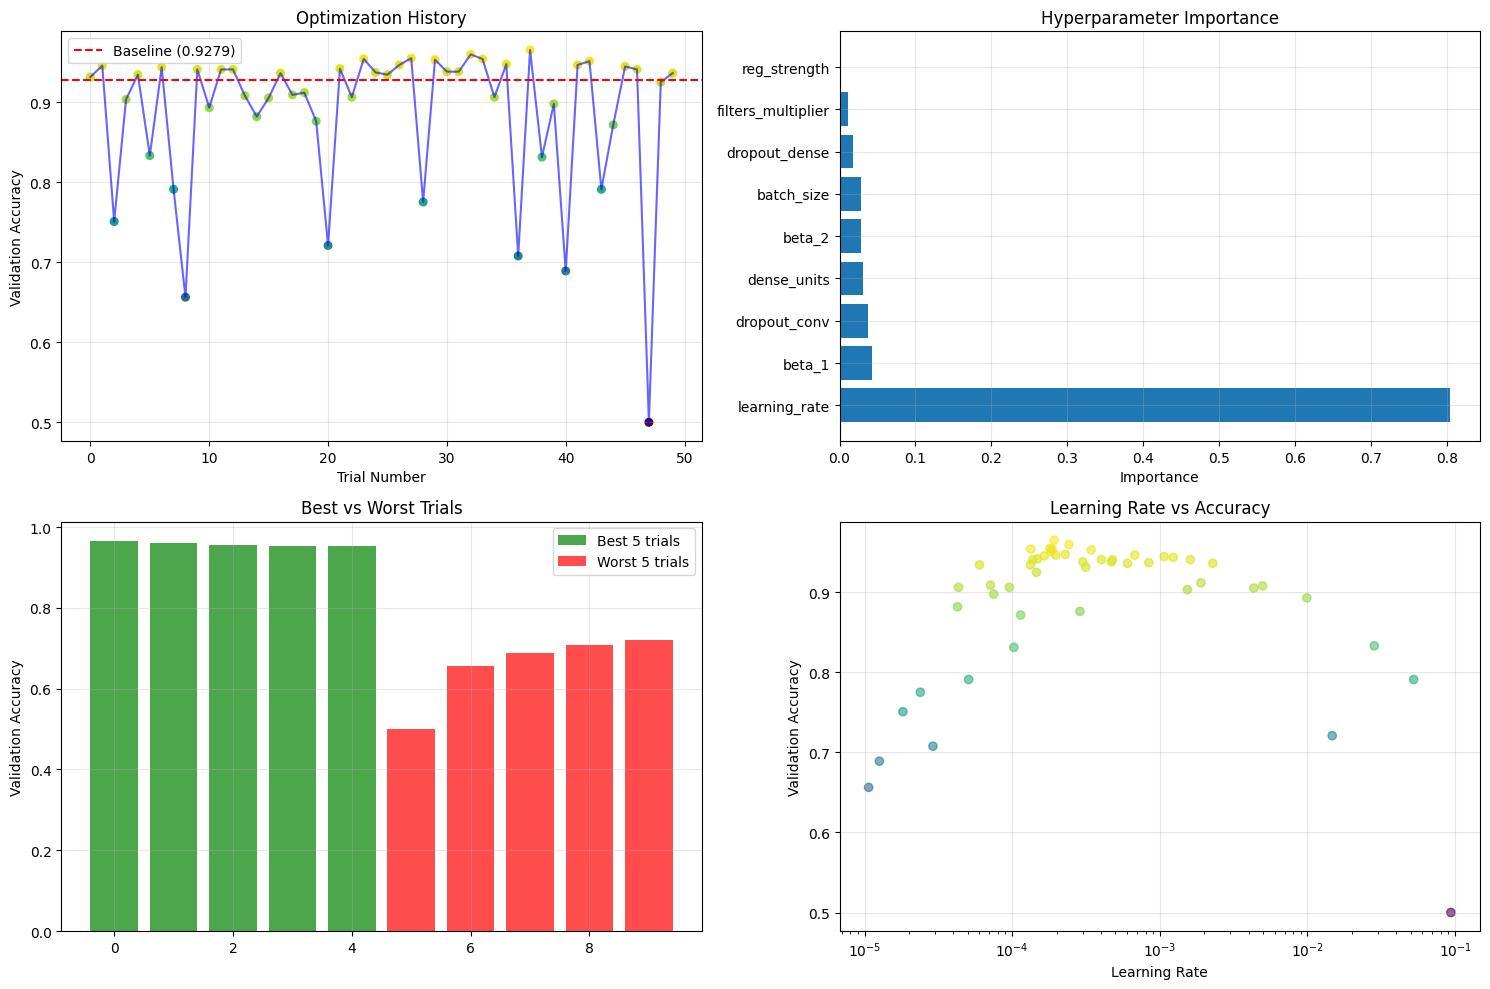

✅ Analysis complete!


In [16]:

def analyze_bayesian_results(study):
    print("\n" + "="*60)
    print("🔥 TRAINING FINAL MODEL WITH BEST PARAMETERS")
    print("="*60)

    best_config = study.best_params
    final_result = train_and_evaluate_model(best_config, epochs=60,
                                            param_name="bayesian_best", param_value="final")

    print("\n📊 FINAL RESULTS COMPARISON:")
    print("="*50)
    print(f"Baseline  - Accuracy: {baseline_result['val_accuracy']:.4f}, AUC: {baseline_result['val_auc']:.4f}")
    print(f"Bayesian  - Accuracy: {final_result['val_accuracy']:.4f}, AUC: {final_result['val_auc']:.4f}")
    print(f"Improvement - Accuracy: {final_result['val_accuracy'] - baseline_result['val_accuracy']:+.4f}, "
          f"AUC: {final_result['val_auc'] - baseline_result['val_auc']:+.4f}")

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    trial_numbers = [t.number for t in study.trials]
    trial_values  = [t.value if t.value is not None else 0 for t in study.trials]
    axes[0,0].plot(trial_numbers, trial_values, 'b-', alpha=0.6)
    sc = axes[0,0].scatter(trial_numbers, trial_values, c=trial_values, cmap='viridis', s=30)
    axes[0,0].axhline(y=baseline_result['val_accuracy'], color='red', linestyle='--',
                      label=f'Baseline ({baseline_result['val_accuracy']:.4f})')
    axes[0,0].set_xlabel('Trial Number'); axes[0,0].set_ylabel('Validation Accuracy')
    axes[0,0].set_title('Optimization History'); axes[0,0].legend(); axes[0,0].grid(True, alpha=0.3)

    try:
        importance = optuna.importance.get_param_importances(study)
        params = list(importance.keys()); values = list(importance.values())
        axes[0,1].barh(params, values)
        axes[0,1].set_xlabel('Importance'); axes[0,1].set_title('Hyperparameter Importance'); axes[0,1].grid(True, alpha=0.3)
    except Exception:
        axes[0,1].text(0.5, 0.5, 'Parameter importance\nnot available\n(need more trials)',
                       ha='center', va='center', transform=axes[0,1].transAxes)
        axes[0,1].set_title('Hyperparameter Importance')

    best_trials  = sorted([t for t in study.trials if t.value is not None], key=lambda t: t.value, reverse=True)[:5]
    worst_trials = sorted([t for t in study.trials if t.value is not None], key=lambda t: t.value)[:5]
    best_values  = [t.value for t in best_trials]
    worst_values = [t.value for t in worst_trials]
    axes[1,0].bar(range(len(best_values)), best_values, color='green', alpha=0.7, label='Best 5 trials')
    axes[1,0].bar(range(len(best_values), len(best_values)+len(worst_values)), worst_values,
                  color='red', alpha=0.7, label='Worst 5 trials')
    axes[1,0].set_ylabel('Validation Accuracy'); axes[1,0].set_title('Best vs Worst Trials')
    axes[1,0].legend(); axes[1,0].grid(True, alpha=0.3)

    lr_values, acc_values = [], []
    for t in study.trials:
        if t.value is not None and 'learning_rate' in t.params:
            lr_values.append(t.params['learning_rate']); acc_values.append(t.value)
    if lr_values:
        axes[1,1].scatter(lr_values, acc_values, alpha=0.6, c=acc_values, cmap='viridis')
        axes[1,1].set_xscale('log'); axes[1,1].set_xlabel('Learning Rate'); axes[1,1].set_ylabel('Validation Accuracy')
        axes[1,1].set_title('Learning Rate vs Accuracy'); axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('bayesian_optimization_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    return final_result, best_config

bayesian_final_result, bayesian_best_config = analyze_bayesian_results(study)
print("✅ Analysis complete!")


In [17]:

def final_summary():
    print("\n" + "="*70)
    print("🎯 BAYESIAN OPTIMIZATION SUMMARY")
    print("="*70)
    baseline_acc = baseline_result['val_accuracy']
    optimized_acc = bayesian_final_result['val_accuracy']
    improvement = optimized_acc - baseline_acc

    print("📈 Performance Improvement:")
    print(f"  Baseline Accuracy:  {baseline_acc:.4f}")
    print(f"  Optimized Accuracy: {optimized_acc:.4f}")
    print(f"  Improvement:        {improvement:+.4f} "
          f"({(improvement / max(1e-9, baseline_acc))*100:+.2f}%)")

    print("\n🏆 Best Configuration Found:")
    for param, value in bayesian_best_config.items():
        baseline_val = BASELINE_CONFIG.get(param, "N/A")
        print(f"  {param:<18}: {str(value):<10} (baseline: {baseline_val})")

    print("\n🔍 Key Insights:")
    print(f"  • Total trials run: {len(study.trials)}")
    print(f"  • Best trial: #{study.best_trial.number}")
    print(f"  • Search space explored efficiently using Bayesian optimization")

    print("\n🚀 Next Steps:")
    print("  • Use the best model for production")
    print("  • Consider ensemble methods")
    print("  • Test on holdout data")
    print("  • Monitor performance in production")

final_summary()



🎯 BAYESIAN OPTIMIZATION SUMMARY
📈 Performance Improvement:
  Baseline Accuracy:  0.9279
  Optimized Accuracy: 0.9663
  Improvement:        +0.0384 (+4.14%)

🏆 Best Configuration Found:
  learning_rate     : 0.00019329441561008272 (baseline: 0.001)
  reg_strength      : 2.1392715033008293e-06 (baseline: 1e-05)
  dropout_conv      : 0.3991746766866793 (baseline: 0.15)
  dropout_dense     : 0.4342883979481444 (baseline: 0.4)
  dense_units       : 1024       (baseline: 512)
  filters_multiplier: 1.897507625889965 (baseline: 0.75)
  batch_size        : 64         (baseline: 128)
  beta_1            : 0.8828029914578701 (baseline: 0.8)
  beta_2            : 0.9358066391956668 (baseline: 0.99)

🔍 Key Insights:
  • Total trials run: 50
  • Best trial: #37
  • Search space explored efficiently using Bayesian optimization

🚀 Next Steps:
  • Use the best model for production
  • Consider ensemble methods
  • Test on holdout data
  • Monitor performance in production
